## Import Packages

1. To build a recurrent neural network, we start by importing the Dense layer, Activation layer, and Loss function that you implemented in Lab4 & Flatten layer you implemented in Lab5. Ensure the following three files are located in the same directory as this notebook, and follow the instructions to complete the setup:
    - Dense.py : Copy the **Dense class** you had implemented in Lab4 to it.
    - Activation.py : Copy the **Activation class** you had implemented in Lab4 to it.
    - Loss.py : Copy **compute_CCE_loss** function you had implemented in Lab4 to it.
    - Flatten.py: Copy **Flatten class** you had implemented in Lab5 to it.\
    Note: you should copy both `forward()` and `backward()` in class `Flatten` in Lab5.


⚠️ **WARNING** ⚠️:
*   Please do not import any other packages in this lab.
*   np.random.seed(seed) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed.

❗ **Important** ❗: Please do not change the code outside this code bracket.
```
### START CODE HERE ###
...
### END CODE HERE ###
```



### Mount Google Drive (optional)

In [1]:
### START CODE HERE ###
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir('YOUR PATH')
### END CODE HERE ###

In [123]:
###### import your Lab4 & Lab5 code (Don't change this part) ######
from Dense import Dense
from Activation import Activation
from Loss import compute_CCE_loss, compute_MSE_loss
from Flatten import Flatten
##################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

outputs = {}

# Basic Part

## RNN Class (30%)
The RNN class implements a simple Recurrent Neural Network (RNN) layer. This class includes methods for initializing parameters, performing the forward pass, computing gradients during the backward pass, and updating the weights.

Structure overview:
<figure> <img src="https://imgur.com/nU7xrBe.png" width="580" height="400">
</figure>
RNN connection:
<figure>
<img src="https://imgur.com/4JQX0se.png" width="500" height="250">
</figure>
Data insights:
<figure> <img src="https://imgur.com/c2MI3mj.png" width="400" height="220">
</figure>
In each neuron:
<figure> <img src="https://imgur.com/luXS4zv.png" width="300" height="220">
</figure>

1.   **Initializaon**

    *   `input_size`: The number of input features for each time step.
    *   `rnn_units`: The number of units (neurons) in the RNN layer.
    *   `seed`: A random seed for weight initialization to ensure reproducibility.

2.   **Initialize parameters** (3%)
    * `Wx`: The weight matrix for the input to hidden connections. It has a shape of `(rnn_units, input_size)`
    * `Wh`: The weight matrix for the hidden to hidden connections. It has a shape of `(rnn_units, rnn_units)`
    * `bh`: The bias vector for the hidden state. It has a shape of `(rnn_units, 1)`, where rnn_units is the number of units in the RNN layer.
3.  **Forward** (12%) \
* `X`: Input data of shape `(batch_size, timesteps, input_size)`
* The forward pass computes the hidden state `h_t` (shape of `(batch_size, self.rnn_units)`)at each time step `t` using the following formula:
$ h_t = \tanh(W_x \cdot x_t + W_h \cdot h_{t-1} + b_h)$
    * $W_x$ is the weight matrix for the input to hidden connections.
    * $W_h$ is the weight matrix for the hidden to hidden connections.
    * $b_h$ is the bias vector.
    * $x_t$ is the input at time step t.
    * $h_{t-1}$ is the hidden state from the previous time step.
    * $\tanh$ is the hyperbolic tangent activation function.
* Output would be shape of `(batch_size, rnn_units)`
4. **Backward** (15%) \
Reference (Backpropagation Through Time):
https://www.pycodemates.com/2023/08/backpropagation-through-time-explained-with-derivations.html
* `dH`: Gradient of the loss with respect to the hidden state, typically of shape `(batch_size, rnn_units, 1)`.
* The backward pass computes the gradients of the loss with respect to the weights and biases using the following formulas:
    * Gradient of the loss with respect to the hidden state(derivative of `tanh`):\
    $\delta_t = (1 - h_t^2) \cdot \delta_{t+1}$
        * $\delta_t$ is the gradient of the loss with respect to the hidden state at time step t.
        * $h_t$ is the hidden state at time step t
    * Gradients with respect to the weights and biases (accumulate the gradients over all time steps):
        1. $\frac{\partial L}{\partial W_x} = ∑_{t=0}^{timesteps} \delta_t^T \cdot x_t$
        2. $\frac{\partial L}{\partial W_h} = ∑_ {t=0}^{timesteps} \delta_t^T \cdot h_{t-1}$
        3. $\frac{\partial L}{\partial b_h} = ∑_{t=0}^{timesteps} \delta_t^T$
        * $\frac{\partial L}{\partial W_x}$ is the gradient of the loss with respect to the input to hidden weights.
        * $\frac{\partial L}{\partial W_h}$ is the gradient of the loss with respect to the hidden to hidden weights.
        * $\frac{\partial L}{\partial b_h}$ is the gradient of the loss with respect to the hidden bias.
        * $x_t$ is the input at time step t.
        * $h_{t-1}$ is the hidden state from the previous time step.
    * Gradient with respect to the previous hidden state:
    $\frac{\partial L}{\partial h_{t-1}} = \delta_t \cdot W_h$
    * Then divide each gradient by `batch_size`.
    * Gradient clipping (optional) is recommended in RNN since RNN rely on backpropagation through time where data might contain large timesteps and it might cause gradient explosion or vanishing. **Note**: You can't do gradient clipping in the function testing (`test_baward()`)


In [188]:
class RNN():
    def __init__(self, input_size, rnn_units, seed=1):
        """
        Initialize the SimpleRNN layer.

        Parameters:
        input_size (int): Number of input features.
        rnn_units (int): Number of units in the RNN layer.
        seed (int): Random seed for weight initialization.
        """
        self.input_size = input_size
        self.rnn_units = rnn_units
        # self.return_sequences = return_sequences
        self.seed = seed
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initialize the weights and biases for the RNN layer.
        """
        np.random.seed(self.seed)

        ### START CODE HERE ###
        # Multiply by 0.01 is for testing reason.
        self.Wx = np.random.randn(self.rnn_units, self.input_size) * 0.01     # Input to hidden weights , with shape of (rnn_units, input_size).
        self.Wh = np.random.randn(self.rnn_units, self.rnn_units) * 0.01     # Hidden to hidden weights, with shape of (rnn_units, rnn_units).
        self.bh = np.zeros((self.rnn_units, 1))     # Hidden bias, with shape of (rnn_units, 1).
        ### END CODE HERE ###

    def forward(self, X):
        """
        Perform the forward pass through the RNN layer.

        Parameters:
        X (ndarray): Input data of shape (batch_size, timesteps, input_size).

        Returns:
        ndarray: Output of the RNN layer (hidden state).
        """
        batch_size, timesteps, _ = X.shape
        ### START CODE HERE ###
        self.h = np.zeros((batch_size, self.rnn_units))       # Initialize hidden state, with shape of (batch_size, self.rnn_units).
        self.hs = []      # Store hidden states for backward pass, list of self.h.
        ### END CODE HERE ###

        self.xs = []  # Store inputs for backward pass

        for t in range(timesteps):
            ### START CODE HERE ###
            x_t = X[:, t, :]              # Get input at time step t for all data in X.
            self.xs.append(x_t)
            self.h = np.tanh(np.dot(x_t, self.Wx.T) + np.dot(self.h, self.Wh.T) + self.bh.T)           # Update hidden state according to the formula of h_t.
            self.hs.append(self.h)  # self.hs.append(self.h.copy())
            ### END CODE HERE ###

        return self.h
        # if self.return_sequences:
        #     return np.stack(self.hs, axis=1)  # (batch_size, timesteps, rnn_units)
        # else:
        #     return self.h  # (batch_size, rnn_units)


    def backward(self, dH):
        """
        Perform the backward pass through the RNN layer.

        Parameters:
        dH (ndarray): Gradient of the loss with respect to the hidden state.
        clip_value (float): Value to clip the gradients to prevent exploding gradients.

        Returns:
        ndarray: Gradient of the loss with respect to the input.
        """
        batch_size, _ = dH.shape
        ### START CODE HERE ###
        self.dL_dWx = np.zeros_like(self.Wx)        # Initialized with same shape as Wx.
        self.dL_dWh = np.zeros_like(self.Wh)        # Initialized with same shape as Wh.
        self.dL_dbh = np.zeros_like(self.bh)        # Initialized with same shape as bh.
        ### END CODE HERE ###
        dL_dh = dH

        for t in reversed(range(len(self.hs))):
            x_t = self.xs[t]  # Get input at time step t
            h = self.hs[t]
            h_prev = self.hs[t-1] if t > 0 else np.zeros_like(h)
            ### START CODE HERE ###
            dL_dh_raw = (1 - h ** 2) * dL_dh     # Derivative of tanh
            self.dL_dWx += np.dot(dL_dh_raw.T, x_t)   # Gradient w.r.t. Wx
            self.dL_dWh += np.dot(dL_dh_raw.T, h_prev)   # Gradient w.r.t. Wh
            self.dL_dbh += np.sum(dL_dh_raw.T, axis=1, keepdims=True)   # Gradient w.r.t. bh
            dL_dh = np.dot(dL_dh_raw, self.Wh)         # Gradient w.r.t. previous hidden state (Wh)
            ### END CODE HERE ###

        ### START CODE HERE ###
        # Average gradients over the batch.
        self.dL_dWx /= batch_size
        self.dL_dWh /= batch_size
        self.dL_dbh /= batch_size
        ### END CODE HERE ###

        ### START CODE HERE ###
        # Gradient part (optional), you can't run this part while testing the backward function !!!
        clip_value = 2.0
        # Clip gradients to prevent exploding gradients
        np.clip(self.dL_dWx, -clip_value, clip_value, out=self.dL_dWx)
        np.clip(self.dL_dWh, -clip_value, clip_value, out=self.dL_dWh)
        np.clip(self.dL_dbh, -clip_value, clip_value, out=self.dL_dbh)
        ### END CODE HERE ###

        return dL_dh

    def update(self, learning_rate):
        """
        Update the weights and biases using the computed gradients.

        Parameters:
        learning_rate (float): Learning rate for weight updates.
        """
        ### START CODE HERE ###
        # Update each weights.
        self.Wx -= learning_rate * self.dL_dWx
        self.Wh -= learning_rate * self.dL_dWh
        self.bh -= learning_rate * self.dL_dbh
        ### END CODE HERE ###

### Functions testing


#### `initialize_parameter` function

In [34]:
def test_initialization(save_to_output = False):
    input_size = 5
    rnn_units = 3
    rnn = RNN(input_size, rnn_units)
    print("Wx shape:", rnn.Wx.shape)
    print("Wh shape:", rnn.Wh.shape)
    print("bh shape:", rnn.bh.shape)
    if save_to_output == True:
        outputs['RNN_initialization'] = {"Wx shape": rnn.Wx.shape, "Wh shape": rnn.Wh.shape, "bh shape": rnn.bh.shape}
test_initialization(True)

Wx shape: (3, 5)
Wh shape: (3, 3)
bh shape: (3, 1)


Expected output:

|Output|Value|
|---|---|
|Wx shape:|(3, 5)|
|Wh shape:|(3, 3)|
|bh shape:|(3, 1)|

#### `forward` function


In [35]:
def test_forward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4
    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    # Create a sample input of shape (batch_size, timesteps, input_size)
    np.random.seed(seed)   # Don't change the seed!
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    output = rnn.forward(X)

    if save_to_output == False:
        # Print the output
        print("Input shape:", X.shape)
        print("Input:")
        print(X)
        print("Output shape of RNN layer:", output.shape)
        print("Output of the RNN layer (hidden state):")
        print(output)

    if save_to_output == True:
        outputs['RNN_forward'] = {"X shape": X.shape, "X": X, "Output shape": output.shape, "Output": output}

# Run the test with seed 1 to compare with expected outputs.
test_forward(1)

# Run with seed 42 and save the answer.
test_forward(42, True)

Input shape: (2, 4, 5)
Input:
[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
  [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
  [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]
  [-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]

 [[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]
  [-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]
  [-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]
  [-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]
Output shape of RNN layer: (2, 3)
Output of the RNN layer (hidden state):
[[-0.00873835  0.02641052 -0.00287992]
 [-0.00596289 -0.01742189  0.02418844]]


Expected output of `forward`:

| Output | Value |
|---|---|
| Input shape | (2, 4, 5) |
| Input | `[[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]`<br>  `[-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]`<br>  `[ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]`<br>  `[-1.09989127 -0.17242821 -0.87785842  0.04221375  0.58281521]]`<br><br> `[[-1.10061918  1.14472371  0.90159072  0.50249434  0.90085595]`<br>  `[-0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547]`<br>  `[-0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613]`<br>  `[-0.0126646  -1.11731035  0.2344157   1.65980218  0.74204416]]]]` |
| Output shape of RNN layer | (2, 3) |
| Output of the RNN layer (hidden state) | `[[-0.00873835  0.02641052 -0.00287992]`<br> `[-0.00596289 -0.01742189  0.02418844]]` |

#### `backward` function

In [37]:
def test_backward(seed, save_to_output = False):
    input_size = 5
    rnn_units = 3
    batch_size = 2
    timesteps = 4

    # Initialize the RNN layer
    rnn = RNN(input_size, rnn_units)
    np.random.seed(seed)   # Don't change the seed!
    # Create a sample input of shape (batch_size, timesteps, input_size)
    X = np.random.randn(batch_size, timesteps, input_size)
    # Perform the forward pass
    rnn.forward(X)
    # Create a sample gradient of the loss with respect to the hidden state
    dH = np.random.randn(batch_size, rnn_units)
    # Perform the backward pass
    dL_dX = rnn.backward(dH)
    if save_to_output == False:
        print("dH shape: ", dH.shape)
        print("dH:")
        print(dH)
        # Print the gradients
        print("dL_dX shape:", dL_dX.shape)
        print("Gradient w.r.t. input (dL_dX):")
        print(dL_dX)
        print("dL_dWx shape:", rnn.dL_dWx.shape)
        print("Gradient w.r.t. Wx (dL_dWx):")
        print(rnn.dL_dWx)
        print("dL_dWh shape:", rnn.dL_dWh.shape)
        print("Gradient w.r.t. Wh (dL_dWh):")
        print(rnn.dL_dWh)
        print("dL_dbh shape:", rnn.dL_dbh.shape)
        print("Gradient w.r.t. bh (dL_dbh):")
        print(rnn.dL_dbh)

    if save_to_output == True:
        outputs['RNN_backward'] = {"dH shape": dH.shape, "dH": dH, "dL_dX shape": dL_dX.shape, "dL_dX": dL_dX, "dL_dWx shape": rnn.dL_dWx.shape,
                                   "dL_dWx": rnn.dL_dWx, "dL_dWh shape": rnn.dL_dWh.shape, "dL_dWh": rnn.dL_dWh, "dL_dbh shape": rnn.dL_dbh.shape, "dL_dbh": rnn.dL_dbh}

# Run the test with seed 1 to compare with expected outputs.
test_backward(1)

# Run with seed 42 and save the answer.
test_backward(42, True)

dH shape:  (2, 3)
dH:
[[-0.19183555 -0.88762896 -0.74715829]
 [ 1.6924546   0.05080775 -0.63699565]]
dL_dX shape: (2, 3)
Gradient w.r.t. input (dL_dX):
[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]
 [ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]
dL_dWx shape: (3, 5)
Gradient w.r.t. Wx (dL_dWx):
[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]
 [ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]
 [ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]
dL_dWh shape: (3, 3)
Gradient w.r.t. Wh (dL_dWh):
[[-0.00663169  0.01738478 -0.0106337 ]
 [-0.02325593  0.03069429 -0.03469078]
 [-0.01936184  0.02200992 -0.02853306]]
dL_dbh shape: (3, 1)
Gradient w.r.t. bh (dL_dbh):
[[ 0.73406116]
 [-0.42812618]
 [-0.69714697]]


Expected output:

| Output | Value |
|---|---|
|dH shape:|(2, 3)|
|dH:|`[[-0.19183555 -0.88762896 -0.74715829]`<br>`[ 1.6924546   0.05080775 -0.63699565]]`|
|dL_dX shape:| (2, 3)|
|Gradient w.r.t. input (dL_dX):| `[[-1.30293142e-08  5.55316892e-09 -2.93987480e-08]`<br>`[ 8.78019041e-09  2.41595285e-08 -1.33357681e-08]]`|
|dL_dWx shape:| (3, 5)|
|Gradient w.r.t. Wx (dL_dWx):|`[[ 0.09855041 -0.91665683  0.29245483  1.41272981  0.57684949]`<br>`[ 0.48200032  0.06164319  0.40009246  0.02920006 -0.24340623]`<br>`[ 0.42661386  0.4160692   0.25830352 -0.53769917 -0.44331323]]`|
|dL_dWh shape:| (3, 3)|
|Gradient w.r.t. Wh (dL_dWh):|`[[-0.00663169  0.01738478 -0.0106337 ]`<br>`[-0.02325593  0.03069429 -0.03469078]`<br>`[-0.01936184  0.02200992 -0.02853306]]`|
|dL_dbh shape:| (3, 1)|
|Gradient w.r.t. bh (dL_dbh):|`[[ 0.73406116]`<br>`[-0.42812618]`<br>`[-0.69714697]]`|

## Model class (10%)
The `Model` class provides a framework for building and training neural networks.
1.   `add()` is just like the function in previous Lab, we can call `model.add( )` to sequentially add a layer into the model.
2.   `forward()` performs the forward propagation of data through the layers, calculating predictions
3.   In `backward()`, we have to check if the activation function is *softmax* to make sure we call the right `backward()`.
4.   `train()` function will be used to train the model, here, we can decide which loss function `BCE` or `MSE` we want to train with. And also calculate the loss for validation data.
5. `plot_losses()` function can show the history of the training and validation loss to see if the training works.

In [85]:
class Model():
    def __init__(self):
        self.layers = []

    def add(self, layer):
        """
        Sequentially add a layer into the model.

        Parameters:
        layer: Different layers class.
        """
        ### START CODE HERE ###
        self.layers.append(layer)
        ### END CODE HERE ###

    def forward(self, X):
        for layer in self.layers:
            if layer.__class__.__name__ == 'RNN':
                if len(X.shape) < 3:                                # If the RNN layer is stacked after another RNN layer.
                    ### START CODE HERE ###
                    X = X.reshape(X.shape[0], 1, -1)                # We have to treat the output size of first layer (rnn_units) as the feature size (input_size) of the second layer.
                    ### END CODE HERE ###
                X = layer.forward(X)
            else:
                X = layer.forward(X)
        return X

    def backward(self, dA, Y):
        for layer in reversed(self.layers):
            if isinstance(layer, Activation) and layer.activation_function == "softmax":
                ### START CODE HERE ###
                dA = layer.backward(dA, Y)                  # softmax activation backward.
                ### END CODE HERE ###
            else:
                ### START CODE HERE ###
                dA = layer.backward(dA)
                ### END CODE HERE ###
        return dA

    def update(self, learning_rate):
        for layer in self.layers:       # Update for every layers.
            ### START CODE HERE ###
            # layer.update(learning_rate)
            if hasattr(layer, 'update'):
                layer.update(learning_rate)
            ### END CODE HERE ###

    def train(self, X_train, y_train, X_val, y_val, epochs=10, learning_rate=0.001, batch_size = 32, loss_function='mse'):
        self.train_losses = []  # Initialize a list to store training losses
        self.val_losses = []  # Initialize a list to store validation losses
        for epoch in range(epochs):
            total_loss = 0
            ### START CODE HERE ###
            num_batches = len(X_train) // batch_size    # Calculate the number of batches
            ### END CODE HERE ###

            with tqdm(total=num_batches, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
                for batch_idx in range(num_batches):

                    ### START CODE HERE ###
                    # Get the batch data
                    start_idx = batch_idx * batch_size
                    end_idx = start_idx + batch_size
                    X_batch = X_train[start_idx:end_idx]
                    y_batch = y_train[start_idx:end_idx]
                    ### END CODE HERE ###

                    ### START CODE HERE ###
                    # 1. Forward to get the prediction.
                    # 2. Calculate the loss according to your parameters ('cce' or 'mse').
                    # 3. Calculate dA.
                    # 4. backward with the calculated dA.
                    # 5. update the parameters.
                    y_pred = self.forward(X_batch)
                    # Compute loss
                    if loss_function == 'cce':
                        loss = compute_CCE_loss(y_pred, y_batch)
                    elif loss_function == 'mse':
                        loss = compute_MSE_loss(y_pred, y_batch)
                    else:
                        raise ValueError("Unsupported loss function")

                    total_loss += loss

                    if loss_function == 'cce':
                        dA = (y_pred - y_batch) / y_batch.shape[0]  # !
                    elif loss_function == 'mse':
                        dA = 2 * (y_pred - y_batch) / y_batch.shape[0]
                    
                    self.backward(dA, y_batch)

                    self.update(learning_rate)
                    ### END CODE HERE ###

                    # Update the progress bar and loss every 5 iterations
                    if (batch_idx + 1) % 5 == 0:
                        pbar.set_postfix(loss=total_loss / (batch_idx + 1))
                    pbar.update(1)  # Increment the progress bar by 1 unit

                # Handle the remaining examples that do not fit into a full batch
                if len(X_train) % batch_size != 0:

                    # Get the remaining data
                    ### START CODE HERE ###
                    X_batch = X_train[num_batches * batch_size:]
                    y_batch = y_train[num_batches * batch_size:]
                    ### END CODE HERE ###

                    ### START CODE HERE ###
                    # Same as above in batch
                    y_pred = self.forward(X_batch)
                    # Compute loss
                    if loss_function == 'cce':
                        loss = compute_CCE_loss(y_pred, y_batch)
                    elif loss_function == 'mse':
                        loss = compute_MSE_loss(y_pred, y_batch)
                    else:
                        raise ValueError("Unsupported loss function")

                    total_loss += loss
                    
                    if loss_function == 'cce':
                        dA = (y_pred - y_batch) / y_batch.shape[0]  # !
                    elif loss_function == 'mse':
                        dA = 2 * (y_pred - y_batch) / y_batch.shape[0]
                    
                    self.backward(dA, y_batch)

                    self.update(learning_rate)
                    ### END CODE HERE ###

            ### START CODE HERE ###
            avg_train_loss = total_loss / (num_batches + (len(X_train) % batch_size > 0))       # Calculate the average loss over batches.
            ### END CODE HERE ###

            self.train_losses.append(avg_train_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

            # Validation part
            ### START CODE HERE ###
            # 1. Get the prediction
            # 2. compute the loss ('mse', 'cce').
            y_pred = self.forward(X_val)

            if loss_function == 'cce':
                val_loss = compute_CCE_loss(y_pred, y_val)
            elif loss_function == 'mse':
                val_loss = compute_MSE_loss(y_pred, y_val)
            ### END CODE HERE ###

            self.val_losses.append(val_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss}')

    def predict(self, X):
        return self.forward(X)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

### `Model` class testing

In [44]:
def test_model_class(seed, save_to_output = False):
    np.random.seed(seed)
    input = np.random.randn(3, 3, 1)
    Y = np.expand_dims(np.array([1,0,1]),-1)

    model = Model()
    model.add(RNN(1, 4))
    model.add(RNN(4, 4))
    model.add(Dense(4, 1))
    model.add(Activation("sigmoid", None))

    AL = model.forward(input)
    dA_prev = model.backward(AL, Y=Y)
    model.update(0.1)
    if save_to_output == False:
        print("AL: ", AL)
        print("dA_prev: ", dA_prev)
        print("Wx of RNN: ", model.layers[0].Wx)
        print("Wh of RNN: ", model.layers[0].Wh)
        print("bh of RNN: ", model.layers[0].bh)

    if save_to_output == True:
        outputs['Model_class'] = {"AL": AL, "dA_prev": dA_prev, "Wx of RNN": model.layers[0].Wx, "Wh of RNN": model.layers[0].Wh, "bh of RNN": model.layers[0].bh}

# Run the test with seed 1 to compare with expected outputs.
test_model_class(1)

# Run with seed 42 and save the answer.
test_model_class(42, True)

AL:  [[0.50002597]
 [0.50011082]
 [0.49998505]]
dA_prev:  [[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]
 [ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]
 [ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]
Wx of RNN:  [[ 0.01609996]
 [-0.00598851]
 [-0.00519148]
 [-0.01059058]]
Wh of RNN:  [[ 0.00865366 -0.02301519  0.01744827 -0.00761178]
 [ 0.00319076 -0.00249388  0.01462095 -0.02060167]
 [-0.00322391 -0.00384067  0.0113376  -0.0109991 ]
 [-0.00172383 -0.00877879  0.00042198  0.00582784]]
bh of RNN:  [[ 0.00017288]
 [-0.00015564]
 [-0.00010827]
 [-0.00016452]]


Expected output:

|Output|Value|
|---|---|
|AL:| `[[0.50002597]`<br>`[0.50011082]`<br>`[0.49998505]]`|
|dA_prev:|`[[ 1.62378331e-09  3.84694676e-09  6.02625343e-09 -1.21805669e-08]`<br>`[ 1.62165475e-09  3.84752280e-09  6.02247634e-09 -1.21748332e-08]`<br>`[ 1.62368851e-09  3.84622277e-09  6.02587086e-09 -1.21793784e-08]]`|
|Wx of RNN:| `[[ 0.01609996]`<br>`[-0.00598851]`<br>`[-0.00519148]`<br>`[-0.01059058]]`|
|Wh of RNN:|`[[ 0.00865366 -0.02301519  0.01744827 -0.00761178]`<br>`[ 0.00319076 -0.00249388  0.01462095 -0.02060167]`<br>`[-0.00322391 -0.00384067  0.0113376  -0.0109991 ]`<br>`[-0.00172383 -0.00877879  0.00042198  0.00582784]]`|
|bh of RNN:|  `[[ 0.00017288]`<br>`[-0.00015564]`<br>`[-0.00010827]`<br>`[-0.00016452]]`|

### Save the above output to `.npy`

In [45]:
assert list(outputs.keys()) == ['RNN_initialization', 'RNN_forward', 'RNN_backward', 'Model_class']
np.save('Lab6_outputs.npy', outputs)
# sanity check for saved outputs
submit = np.load("Lab6_outputs.npy", allow_pickle=True).item()
for key, value in submit.items():
    if isinstance(value, dict):  # Check if value is a dictionary
        print(f"{key}:")
        for inner_key, inner_value in value.items():
            print(f"  {inner_key}: {type(inner_value)}")  # Print type of inner values
    else:
        print(f"{key}: {type(value)}")  # Print type of other values

RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>


Expected output:


```
RNN_initialization:
  Wx shape: <class 'tuple'>
  Wh shape: <class 'tuple'>
  bh shape: <class 'tuple'>
RNN_forward:
  X shape: <class 'tuple'>
  X: <class 'numpy.ndarray'>
  Output shape: <class 'tuple'>
  Output: <class 'numpy.ndarray'>
RNN_backward:
  dH shape: <class 'tuple'>
  dH: <class 'numpy.ndarray'>
  dL_dX shape: <class 'tuple'>
  dL_dX: <class 'numpy.ndarray'>
  dL_dWx shape: <class 'tuple'>
  dL_dWx: <class 'numpy.ndarray'>
  dL_dWh shape: <class 'tuple'>
  dL_dWh: <class 'numpy.ndarray'>
  dL_dbh shape: <class 'tuple'>
  dL_dbh: <class 'numpy.ndarray'>
Model_class:
  AL: <class 'numpy.ndarray'>
  dA_prev: <class 'numpy.ndarray'>
  Wx of RNN: <class 'numpy.ndarray'>
  Wh of RNN: <class 'numpy.ndarray'>
  bh of RNN: <class 'numpy.ndarray'>
```



## Sinusoidal wave dataset (20%)
In this section, we will generate a dataset of sinusoidal waves with varying frequencies, amplitudes, and random phase shifts. The **last value** in each sequence will be used as the target prediction. This dataset will be used for training and validating a model.



*   You can decide how many `num_samples`, `num_timesteps`, `freq_range` and `amp_range` you want to generate your own training dataset. (**there is no provided training dataset!**)
* ⚠⚠ You need to download X_test.csv from Kaggle and put it into Sinewave directory. (Or you have to change the path when generating prediction)
* For **testing data** on Kaggle, we used `num_timesteps = 100`, `0.5 <= freq_range <= 5` & `0.5 <= amp_range <= 5` to generate, your training dataset can try to cover these range in testing data.
* You need submit the `y_test.csv` to Kaggle
    * `MAPE <= 17%` -> 10 points
    * `MAPE <= 14%` -> 20 points
* **Kaggle Link**: https://www.kaggle.com/t/512f44fe285d4c1bb90c39884f8a2a33

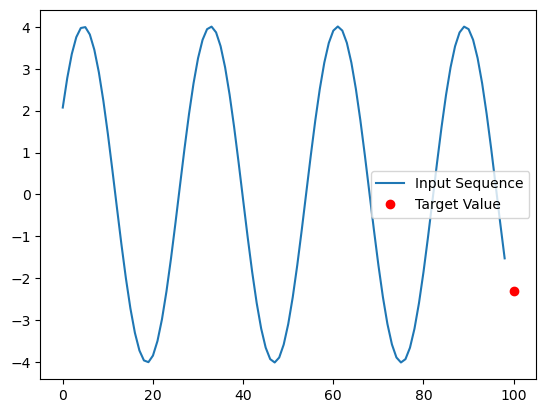

In [63]:
# Generate Sinusoidal Wave Dataset

def generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range):
    """
    Generate sine wave data with varying frequencies, amplitudes, and random phase shifts.
    The last value in each sequence is used as the target prediction.

    Parameters:
    - num_samples: Number of samples to generate.
    - num_timesteps: Number of timesteps for each sample.
    - freq_range: Tuple of floor and ceiling of frequency range.
    - amp_range: Tuple of floor and ceiling of amplitude range.

    Returns:
    - X: Generated sine wave data of shape (num_samples, num_timesteps - 1).
    - y: Target values of shape (num_samples,).
    """
    X = np.zeros((num_samples, num_timesteps - 1))
    y = np.zeros(num_samples)
    for i in range(num_samples):
        ### START CODE HERE ###
        # Choose the frequency, amplitude and shift phase value.
        freq = np.random.uniform(*freq_range)             # Random choose from freq_range.
        amp = np.random.uniform(*amp_range)              # Random choose from amp_range.
        phase_shift = np.random.uniform(0, 2 * np.pi)      # Random choose from (0, 2*pi).
        ### END CODE HERE ###

        t = np.linspace(0, 2 * np.pi, num_timesteps)
        sine_wave = amp * np.sin(freq * t + phase_shift)
        X[i] = sine_wave[:-1]  # All but the last value
        y[i] = sine_wave[-1]   # The last value
    return X, y

### START CODE HERE ###
# You can modify to your preferred range and number of samples. (Note: It's recommended to cover the range of testing data mentioned above.)
num_samples = 1600
num_timesteps = 100
freq_range = (0.5, 5.0)  # Frequency range  # 10
amp_range = (0.5, 5.0)   # Amplitude range  # 10
### END CODE HERE ###

X, y = generate_sine_wave_data(num_samples, num_timesteps, freq_range, amp_range)

### START CODE HERE ###
# Split data into training and validation sets
split_idx = int(0.8 * num_samples)  # 80% training, 20% validation
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]
### END CODE HERE ###

# Plot an example sequence
plt.plot(X_train[0], label='Input Sequence')
plt.plot(np.arange(num_timesteps, num_timesteps + 1), y_train[0], 'ro', label='Target Value')
plt.legend()
plt.show()


### Construct the model with Dense layer only
Here, we want you to construct the model with **Dense layer only** like you did in Lab4. You may modify the model structure and parameters in the way you like.

Epoch 1/200: 100%|██████████| 160/160 [00:00<00:00, 3388.84batch/s, loss=14.3]


Epoch 1/200, Training Loss: 14.320253053810157
Epoch 1/200, Validation Loss: 6.358881224015014


Epoch 2/200: 100%|██████████| 160/160 [00:00<00:00, 4585.76batch/s, loss=4.68]


Epoch 2/200, Training Loss: 4.675878417974219
Epoch 2/200, Validation Loss: 4.2757506700548635


Epoch 3/200: 100%|██████████| 160/160 [00:00<00:00, 5555.37batch/s, loss=3.04]


Epoch 3/200, Training Loss: 3.0354163040483995
Epoch 3/200, Validation Loss: 3.227106025617299


Epoch 4/200: 100%|██████████| 160/160 [00:00<00:00, 5269.81batch/s, loss=2.24]


Epoch 4/200, Training Loss: 2.244774318185961
Epoch 4/200, Validation Loss: 2.554059595967537


Epoch 5/200: 100%|██████████| 160/160 [00:00<00:00, 5365.32batch/s, loss=1.77]


Epoch 5/200, Training Loss: 1.7705695041960159
Epoch 5/200, Validation Loss: 2.1010027396612405


Epoch 6/200: 100%|██████████| 160/160 [00:00<00:00, 5373.78batch/s, loss=1.46]


Epoch 6/200, Training Loss: 1.4582477549627568
Epoch 6/200, Validation Loss: 1.7749015459364479


Epoch 7/200: 100%|██████████| 160/160 [00:00<00:00, 4443.82batch/s, loss=1.24]


Epoch 7/200, Training Loss: 1.2400978909480662
Epoch 7/200, Validation Loss: 1.532871603619597


Epoch 8/200: 100%|██████████| 160/160 [00:00<00:00, 3574.68batch/s, loss=1.08]


Epoch 8/200, Training Loss: 1.078838410593363
Epoch 8/200, Validation Loss: 1.351831177657102


Epoch 9/200: 100%|██████████| 160/160 [00:00<00:00, 4484.87batch/s, loss=0.957]


Epoch 9/200, Training Loss: 0.9569893054271683
Epoch 9/200, Validation Loss: 1.2123977970657576


Epoch 10/200: 100%|██████████| 160/160 [00:00<00:00, 4297.11batch/s, loss=0.861]


Epoch 10/200, Training Loss: 0.86051597667982
Epoch 10/200, Validation Loss: 1.1040235698827214


Epoch 11/200: 100%|██████████| 160/160 [00:00<00:00, 4401.04batch/s, loss=0.783]


Epoch 11/200, Training Loss: 0.782972682603599
Epoch 11/200, Validation Loss: 1.0208081986722686


Epoch 12/200: 100%|██████████| 160/160 [00:00<00:00, 4867.41batch/s, loss=0.719]


Epoch 12/200, Training Loss: 0.7187355315959483
Epoch 12/200, Validation Loss: 0.9557099891994192


Epoch 13/200: 100%|██████████| 160/160 [00:00<00:00, 5099.77batch/s, loss=0.665]


Epoch 13/200, Training Loss: 0.6645243089499494
Epoch 13/200, Validation Loss: 0.9033848508590604


Epoch 14/200: 100%|██████████| 160/160 [00:00<00:00, 4345.73batch/s, loss=0.617]


Epoch 14/200, Training Loss: 0.617492474970117
Epoch 14/200, Validation Loss: 0.8630701791046399


Epoch 15/200: 100%|██████████| 160/160 [00:00<00:00, 3832.10batch/s, loss=0.577]


Epoch 15/200, Training Loss: 0.5769933217394654
Epoch 15/200, Validation Loss: 0.8308233550091053


Epoch 16/200: 100%|██████████| 160/160 [00:00<00:00, 4603.43batch/s, loss=0.541]


Epoch 16/200, Training Loss: 0.5412958177835964
Epoch 16/200, Validation Loss: 0.8053152042694536


Epoch 17/200: 100%|██████████| 160/160 [00:00<00:00, 4900.82batch/s, loss=0.509]


Epoch 17/200, Training Loss: 0.5093706397904572
Epoch 17/200, Validation Loss: 0.7851481997535441


Epoch 18/200: 100%|██████████| 160/160 [00:00<00:00, 5225.94batch/s, loss=0.481]


Epoch 18/200, Training Loss: 0.48074157627736414
Epoch 18/200, Validation Loss: 0.7673124062856678


Epoch 19/200: 100%|██████████| 160/160 [00:00<00:00, 5352.95batch/s, loss=0.455]


Epoch 19/200, Training Loss: 0.45512341734855155
Epoch 19/200, Validation Loss: 0.7538512272921718


Epoch 20/200: 100%|██████████| 160/160 [00:00<00:00, 5552.57batch/s, loss=0.432]


Epoch 20/200, Training Loss: 0.43156348133308153
Epoch 20/200, Validation Loss: 0.7414704315397806


Epoch 21/200: 100%|██████████| 160/160 [00:00<00:00, 5793.09batch/s, loss=0.41] 


Epoch 21/200, Training Loss: 0.41045196504781345
Epoch 21/200, Validation Loss: 0.7321251729209215


Epoch 22/200: 100%|██████████| 160/160 [00:00<00:00, 5431.94batch/s, loss=0.391]


Epoch 22/200, Training Loss: 0.39092958238031994
Epoch 22/200, Validation Loss: 0.723230622173359


Epoch 23/200: 100%|██████████| 160/160 [00:00<00:00, 5107.84batch/s, loss=0.373]


Epoch 23/200, Training Loss: 0.37286062100894624
Epoch 23/200, Validation Loss: 0.7174554696025975


Epoch 24/200: 100%|██████████| 160/160 [00:00<00:00, 5515.37batch/s, loss=0.357]


Epoch 24/200, Training Loss: 0.356932261646067
Epoch 24/200, Validation Loss: 0.710376917704377


Epoch 25/200: 100%|██████████| 160/160 [00:00<00:00, 5181.27batch/s, loss=0.342]


Epoch 25/200, Training Loss: 0.34215502601722986
Epoch 25/200, Validation Loss: 0.706068172384318


Epoch 26/200: 100%|██████████| 160/160 [00:00<00:00, 5474.07batch/s, loss=0.328]


Epoch 26/200, Training Loss: 0.3283804183615818
Epoch 26/200, Validation Loss: 0.7003005099573157


Epoch 27/200: 100%|██████████| 160/160 [00:00<00:00, 3524.14batch/s, loss=0.316]


Epoch 27/200, Training Loss: 0.3156674688087752
Epoch 27/200, Validation Loss: 0.695602018624606


Epoch 28/200: 100%|██████████| 160/160 [00:00<00:00, 5009.99batch/s, loss=0.304]


Epoch 28/200, Training Loss: 0.3035763733748797
Epoch 28/200, Validation Loss: 0.6915967562205152


Epoch 29/200: 100%|██████████| 160/160 [00:00<00:00, 5162.70batch/s, loss=0.292]


Epoch 29/200, Training Loss: 0.2923492310701266
Epoch 29/200, Validation Loss: 0.6882711071842945


Epoch 30/200: 100%|██████████| 160/160 [00:00<00:00, 5186.28batch/s, loss=0.282]


Epoch 30/200, Training Loss: 0.2820301204275076
Epoch 30/200, Validation Loss: 0.6840109683634568


Epoch 31/200: 100%|██████████| 160/160 [00:00<00:00, 5216.35batch/s, loss=0.272]


Epoch 31/200, Training Loss: 0.27241582937940095
Epoch 31/200, Validation Loss: 0.6809967120732074


Epoch 32/200: 100%|██████████| 160/160 [00:00<00:00, 5196.76batch/s, loss=0.263]


Epoch 32/200, Training Loss: 0.26347250014434304
Epoch 32/200, Validation Loss: 0.6784324445359519


Epoch 33/200: 100%|██████████| 160/160 [00:00<00:00, 4933.24batch/s, loss=0.255]


Epoch 33/200, Training Loss: 0.2551205118357964
Epoch 33/200, Validation Loss: 0.6751599686196981


Epoch 34/200: 100%|██████████| 160/160 [00:00<00:00, 5181.95batch/s, loss=0.247]


Epoch 34/200, Training Loss: 0.2471189154529269
Epoch 34/200, Validation Loss: 0.6712917929883684


Epoch 35/200: 100%|██████████| 160/160 [00:00<00:00, 5587.66batch/s, loss=0.24] 


Epoch 35/200, Training Loss: 0.23976475784769852
Epoch 35/200, Validation Loss: 0.6686766561393442


Epoch 36/200: 100%|██████████| 160/160 [00:00<00:00, 5514.33batch/s, loss=0.233]


Epoch 36/200, Training Loss: 0.23280066306897435
Epoch 36/200, Validation Loss: 0.6658755186996418


Epoch 37/200: 100%|██████████| 160/160 [00:00<00:00, 4404.13batch/s, loss=0.226]


Epoch 37/200, Training Loss: 0.22649866777949948
Epoch 37/200, Validation Loss: 0.6640120542466884


Epoch 38/200: 100%|██████████| 160/160 [00:00<00:00, 5411.87batch/s, loss=0.22] 


Epoch 38/200, Training Loss: 0.2202902206144302
Epoch 38/200, Validation Loss: 0.6613735872577104


Epoch 39/200: 100%|██████████| 160/160 [00:00<00:00, 5182.55batch/s, loss=0.214]


Epoch 39/200, Training Loss: 0.21445773458585102
Epoch 39/200, Validation Loss: 0.6582503161347522


Epoch 40/200: 100%|██████████| 160/160 [00:00<00:00, 4139.71batch/s, loss=0.209]


Epoch 40/200, Training Loss: 0.20919870589300066
Epoch 40/200, Validation Loss: 0.6567379035097104


Epoch 41/200: 100%|██████████| 160/160 [00:00<00:00, 4558.31batch/s, loss=0.204]


Epoch 41/200, Training Loss: 0.2039887159300075
Epoch 41/200, Validation Loss: 0.6521224121223705


Epoch 42/200: 100%|██████████| 160/160 [00:00<00:00, 5391.61batch/s, loss=0.199]


Epoch 42/200, Training Loss: 0.1990995655724655
Epoch 42/200, Validation Loss: 0.6502510787965259


Epoch 43/200: 100%|██████████| 160/160 [00:00<00:00, 5334.95batch/s, loss=0.195]


Epoch 43/200, Training Loss: 0.19464975582979102
Epoch 43/200, Validation Loss: 0.6487036465788251


Epoch 44/200: 100%|██████████| 160/160 [00:00<00:00, 5263.56batch/s, loss=0.19] 


Epoch 44/200, Training Loss: 0.19024585168248753
Epoch 44/200, Validation Loss: 0.6460268350716006


Epoch 45/200: 100%|██████████| 160/160 [00:00<00:00, 5266.08batch/s, loss=0.186]


Epoch 45/200, Training Loss: 0.1862298307110713
Epoch 45/200, Validation Loss: 0.6436852022920929


Epoch 46/200: 100%|██████████| 160/160 [00:00<00:00, 5116.25batch/s, loss=0.182]


Epoch 46/200, Training Loss: 0.18237639858315807
Epoch 46/200, Validation Loss: 0.641829759634227


Epoch 47/200: 100%|██████████| 160/160 [00:00<00:00, 5172.80batch/s, loss=0.179]


Epoch 47/200, Training Loss: 0.17857356346596343
Epoch 47/200, Validation Loss: 0.6392412917960233


Epoch 48/200: 100%|██████████| 160/160 [00:00<00:00, 5275.15batch/s, loss=0.175]


Epoch 48/200, Training Loss: 0.17518868900315926
Epoch 48/200, Validation Loss: 0.6385061917889452


Epoch 49/200: 100%|██████████| 160/160 [00:00<00:00, 5362.87batch/s, loss=0.172]


Epoch 49/200, Training Loss: 0.17168276804228713
Epoch 49/200, Validation Loss: 0.6350231802795685


Epoch 50/200: 100%|██████████| 160/160 [00:00<00:00, 5150.69batch/s, loss=0.168]


Epoch 50/200, Training Loss: 0.16848585627062365
Epoch 50/200, Validation Loss: 0.6329580993408123


Epoch 51/200: 100%|██████████| 160/160 [00:00<00:00, 5166.67batch/s, loss=0.165]


Epoch 51/200, Training Loss: 0.16544900590651285
Epoch 51/200, Validation Loss: 0.6303304575214591


Epoch 52/200: 100%|██████████| 160/160 [00:00<00:00, 5498.70batch/s, loss=0.162]


Epoch 52/200, Training Loss: 0.16239323175028705
Epoch 52/200, Validation Loss: 0.6284270796780544


Epoch 53/200: 100%|██████████| 160/160 [00:00<00:00, 3982.75batch/s, loss=0.16] 


Epoch 53/200, Training Loss: 0.15967875534872178
Epoch 53/200, Validation Loss: 0.6241727669304343


Epoch 54/200: 100%|██████████| 160/160 [00:00<00:00, 4487.81batch/s, loss=0.157]


Epoch 54/200, Training Loss: 0.15703575083932886
Epoch 54/200, Validation Loss: 0.6222422914426478


Epoch 55/200: 100%|██████████| 160/160 [00:00<00:00, 5219.76batch/s, loss=0.154]


Epoch 55/200, Training Loss: 0.1544680691487339
Epoch 55/200, Validation Loss: 0.6189113110077891


Epoch 56/200: 100%|██████████| 160/160 [00:00<00:00, 5380.68batch/s, loss=0.152]


Epoch 56/200, Training Loss: 0.15201470213095578
Epoch 56/200, Validation Loss: 0.6156429455790168


Epoch 57/200: 100%|██████████| 160/160 [00:00<00:00, 4470.02batch/s, loss=0.15] 


Epoch 57/200, Training Loss: 0.14990155957910561
Epoch 57/200, Validation Loss: 0.6139693958608032


Epoch 58/200: 100%|██████████| 160/160 [00:00<00:00, 4959.34batch/s, loss=0.148]


Epoch 58/200, Training Loss: 0.14760551820897455
Epoch 58/200, Validation Loss: 0.6101488523632901


Epoch 59/200: 100%|██████████| 160/160 [00:00<00:00, 4965.18batch/s, loss=0.146]


Epoch 59/200, Training Loss: 0.14551952253169922
Epoch 59/200, Validation Loss: 0.6078398515881154


Epoch 60/200: 100%|██████████| 160/160 [00:00<00:00, 5413.36batch/s, loss=0.143]


Epoch 60/200, Training Loss: 0.14337174184019946
Epoch 60/200, Validation Loss: 0.6039354297540906


Epoch 61/200: 100%|██████████| 160/160 [00:00<00:00, 4624.43batch/s, loss=0.141]


Epoch 61/200, Training Loss: 0.14142925184799024
Epoch 61/200, Validation Loss: 0.6016832577793321


Epoch 62/200: 100%|██████████| 160/160 [00:00<00:00, 5116.41batch/s, loss=0.14] 


Epoch 62/200, Training Loss: 0.13951690617251303
Epoch 62/200, Validation Loss: 0.599218291230459


Epoch 63/200: 100%|██████████| 160/160 [00:00<00:00, 4998.05batch/s, loss=0.138]


Epoch 63/200, Training Loss: 0.1376142339804362
Epoch 63/200, Validation Loss: 0.5952698562797183


Epoch 64/200: 100%|██████████| 160/160 [00:00<00:00, 5434.66batch/s, loss=0.136]


Epoch 64/200, Training Loss: 0.13590113337788914
Epoch 64/200, Validation Loss: 0.5930252078761348


Epoch 65/200: 100%|██████████| 160/160 [00:00<00:00, 5713.24batch/s, loss=0.134]


Epoch 65/200, Training Loss: 0.13408886957823857
Epoch 65/200, Validation Loss: 0.5889805665360538


Epoch 66/200: 100%|██████████| 160/160 [00:00<00:00, 3392.68batch/s, loss=0.132]


Epoch 66/200, Training Loss: 0.13248235576430295
Epoch 66/200, Validation Loss: 0.5871472928325926


Epoch 67/200: 100%|██████████| 160/160 [00:00<00:00, 4539.81batch/s, loss=0.131]


Epoch 67/200, Training Loss: 0.13081874583379607
Epoch 67/200, Validation Loss: 0.5831682098486113


Epoch 68/200: 100%|██████████| 160/160 [00:00<00:00, 5492.53batch/s, loss=0.129]


Epoch 68/200, Training Loss: 0.12936440345089087
Epoch 68/200, Validation Loss: 0.5807386294218524


Epoch 69/200: 100%|██████████| 160/160 [00:00<00:00, 5445.73batch/s, loss=0.128]


Epoch 69/200, Training Loss: 0.12779349492756556
Epoch 69/200, Validation Loss: 0.5778493555078035


Epoch 70/200: 100%|██████████| 160/160 [00:00<00:00, 5194.95batch/s, loss=0.126]


Epoch 70/200, Training Loss: 0.12634409262711427
Epoch 70/200, Validation Loss: 0.5737763745278237


Epoch 71/200: 100%|██████████| 160/160 [00:00<00:00, 5679.35batch/s, loss=0.125]


Epoch 71/200, Training Loss: 0.12492803612135228
Epoch 71/200, Validation Loss: 0.5717529487848368


Epoch 72/200: 100%|██████████| 160/160 [00:00<00:00, 5180.19batch/s, loss=0.124]


Epoch 72/200, Training Loss: 0.12358377013388082
Epoch 72/200, Validation Loss: 0.5673066838748373


Epoch 73/200: 100%|██████████| 160/160 [00:00<00:00, 5395.38batch/s, loss=0.122]


Epoch 73/200, Training Loss: 0.12229193014155819
Epoch 73/200, Validation Loss: 0.5652263992675172


Epoch 74/200: 100%|██████████| 160/160 [00:00<00:00, 5049.16batch/s, loss=0.121]


Epoch 74/200, Training Loss: 0.1210209221090788
Epoch 74/200, Validation Loss: 0.560976232958809


Epoch 75/200: 100%|██████████| 160/160 [00:00<00:00, 3620.58batch/s, loss=0.12] 


Epoch 75/200, Training Loss: 0.11976877909066377
Epoch 75/200, Validation Loss: 0.5589011681154515


Epoch 76/200: 100%|██████████| 160/160 [00:00<00:00, 4384.51batch/s, loss=0.119]


Epoch 76/200, Training Loss: 0.11852882358684988
Epoch 76/200, Validation Loss: 0.5554840895735089


Epoch 77/200: 100%|██████████| 160/160 [00:00<00:00, 5235.19batch/s, loss=0.117]


Epoch 77/200, Training Loss: 0.11737639618878237
Epoch 77/200, Validation Loss: 0.5519333498788751


Epoch 78/200: 100%|██████████| 160/160 [00:00<00:00, 4902.75batch/s, loss=0.116]


Epoch 78/200, Training Loss: 0.11617200334942168
Epoch 78/200, Validation Loss: 0.5491145348155387


Epoch 79/200: 100%|██████████| 160/160 [00:00<00:00, 5181.91batch/s, loss=0.115]


Epoch 79/200, Training Loss: 0.11497022311397584
Epoch 79/200, Validation Loss: 0.5461852136467321


Epoch 80/200: 100%|██████████| 160/160 [00:00<00:00, 5489.39batch/s, loss=0.114]


Epoch 80/200, Training Loss: 0.11382475796263761
Epoch 80/200, Validation Loss: 0.5425905087743633


Epoch 81/200: 100%|██████████| 160/160 [00:00<00:00, 5128.76batch/s, loss=0.113]


Epoch 81/200, Training Loss: 0.11278248719782022
Epoch 81/200, Validation Loss: 0.5397064341462056


Epoch 82/200: 100%|██████████| 160/160 [00:00<00:00, 5158.93batch/s, loss=0.112]


Epoch 82/200, Training Loss: 0.11175516425582685
Epoch 82/200, Validation Loss: 0.5362561997779801


Epoch 83/200: 100%|██████████| 160/160 [00:00<00:00, 5190.69batch/s, loss=0.111]


Epoch 83/200, Training Loss: 0.1106239097030689
Epoch 83/200, Validation Loss: 0.5337607928676504


Epoch 84/200: 100%|██████████| 160/160 [00:00<00:00, 5144.57batch/s, loss=0.11] 


Epoch 84/200, Training Loss: 0.10964828200514769
Epoch 84/200, Validation Loss: 0.5306063904411727


Epoch 85/200: 100%|██████████| 160/160 [00:00<00:00, 5511.80batch/s, loss=0.109]


Epoch 85/200, Training Loss: 0.1086401756147473
Epoch 85/200, Validation Loss: 0.5267314291836961


Epoch 86/200: 100%|██████████| 160/160 [00:00<00:00, 5149.66batch/s, loss=0.108] 


Epoch 86/200, Training Loss: 0.10768627990293012
Epoch 86/200, Validation Loss: 0.5244446669967803


Epoch 87/200: 100%|██████████| 160/160 [00:00<00:00, 5108.31batch/s, loss=0.107] 


Epoch 87/200, Training Loss: 0.10668273347823351
Epoch 87/200, Validation Loss: 0.5212216245251375


Epoch 88/200: 100%|██████████| 160/160 [00:00<00:00, 3785.24batch/s, loss=0.106] 


Epoch 88/200, Training Loss: 0.10575338579282453
Epoch 88/200, Validation Loss: 0.5175449243139643


Epoch 89/200: 100%|██████████| 160/160 [00:00<00:00, 4230.74batch/s, loss=0.105] 


Epoch 89/200, Training Loss: 0.10481280224261633
Epoch 89/200, Validation Loss: 0.5146397855600704


Epoch 90/200: 100%|██████████| 160/160 [00:00<00:00, 5050.22batch/s, loss=0.104] 


Epoch 90/200, Training Loss: 0.1038921439644079
Epoch 90/200, Validation Loss: 0.5111991208304576


Epoch 91/200: 100%|██████████| 160/160 [00:00<00:00, 4603.62batch/s, loss=0.103] 


Epoch 91/200, Training Loss: 0.10308428815218491
Epoch 91/200, Validation Loss: 0.5086313246523114


Epoch 92/200: 100%|██████████| 160/160 [00:00<00:00, 4863.67batch/s, loss=0.102] 


Epoch 92/200, Training Loss: 0.10212926110163392
Epoch 92/200, Validation Loss: 0.5063480760926938


Epoch 93/200: 100%|██████████| 160/160 [00:00<00:00, 5033.59batch/s, loss=0.101] 


Epoch 93/200, Training Loss: 0.1013245556129603
Epoch 93/200, Validation Loss: 0.5022566290550339


Epoch 94/200: 100%|██████████| 160/160 [00:00<00:00, 5170.45batch/s, loss=0.101] 


Epoch 94/200, Training Loss: 0.10051916190527059
Epoch 94/200, Validation Loss: 0.5006504266325339


Epoch 95/200: 100%|██████████| 160/160 [00:00<00:00, 5218.46batch/s, loss=0.0997]


Epoch 95/200, Training Loss: 0.09966808681342025
Epoch 95/200, Validation Loss: 0.4968760070595295


Epoch 96/200: 100%|██████████| 160/160 [00:00<00:00, 4658.46batch/s, loss=0.0989]


Epoch 96/200, Training Loss: 0.0988869948740733
Epoch 96/200, Validation Loss: 0.4943996403911614


Epoch 97/200: 100%|██████████| 160/160 [00:00<00:00, 4770.90batch/s, loss=0.0981]


Epoch 97/200, Training Loss: 0.09813551813985774
Epoch 97/200, Validation Loss: 0.49159769529672676


Epoch 98/200: 100%|██████████| 160/160 [00:00<00:00, 4751.74batch/s, loss=0.0973]


Epoch 98/200, Training Loss: 0.09731958221367992
Epoch 98/200, Validation Loss: 0.48920861429917645


Epoch 99/200: 100%|██████████| 160/160 [00:00<00:00, 5262.57batch/s, loss=0.0966]


Epoch 99/200, Training Loss: 0.09658366084613498
Epoch 99/200, Validation Loss: 0.486651894397687


Epoch 100/200: 100%|██████████| 160/160 [00:00<00:00, 5286.58batch/s, loss=0.0958]


Epoch 100/200, Training Loss: 0.09581679176973687
Epoch 100/200, Validation Loss: 0.483707124028264


Epoch 101/200: 100%|██████████| 160/160 [00:00<00:00, 3657.46batch/s, loss=0.0951]


Epoch 101/200, Training Loss: 0.0951360157887984
Epoch 101/200, Validation Loss: 0.4810359074634383


Epoch 102/200: 100%|██████████| 160/160 [00:00<00:00, 4826.10batch/s, loss=0.0944]


Epoch 102/200, Training Loss: 0.09439258937032886
Epoch 102/200, Validation Loss: 0.4788763499255768


Epoch 103/200: 100%|██████████| 160/160 [00:00<00:00, 4894.31batch/s, loss=0.0937]


Epoch 103/200, Training Loss: 0.0936674053954199
Epoch 103/200, Validation Loss: 0.4756961418768187


Epoch 104/200: 100%|██████████| 160/160 [00:00<00:00, 5309.62batch/s, loss=0.093] 


Epoch 104/200, Training Loss: 0.09300842293327646
Epoch 104/200, Validation Loss: 0.47313064353027623


Epoch 105/200: 100%|██████████| 160/160 [00:00<00:00, 5326.78batch/s, loss=0.0923]


Epoch 105/200, Training Loss: 0.09229248215947236
Epoch 105/200, Validation Loss: 0.47008343288647847


Epoch 106/200: 100%|██████████| 160/160 [00:00<00:00, 5238.79batch/s, loss=0.0916]


Epoch 106/200, Training Loss: 0.09164025257406218
Epoch 106/200, Validation Loss: 0.46755747892058364


Epoch 107/200: 100%|██████████| 160/160 [00:00<00:00, 5459.96batch/s, loss=0.091] 


Epoch 107/200, Training Loss: 0.0909636794044156
Epoch 107/200, Validation Loss: 0.4646437953863973


Epoch 108/200: 100%|██████████| 160/160 [00:00<00:00, 5430.05batch/s, loss=0.0903]


Epoch 108/200, Training Loss: 0.09029559438754865
Epoch 108/200, Validation Loss: 0.46139482500790996


Epoch 109/200: 100%|██████████| 160/160 [00:00<00:00, 5212.26batch/s, loss=0.0896]


Epoch 109/200, Training Loss: 0.08962518199344559
Epoch 109/200, Validation Loss: 0.4592044437458501


Epoch 110/200: 100%|██████████| 160/160 [00:00<00:00, 5400.51batch/s, loss=0.089] 


Epoch 110/200, Training Loss: 0.08903020483809682
Epoch 110/200, Validation Loss: 0.4565257845933789


Epoch 111/200: 100%|██████████| 160/160 [00:00<00:00, 5464.71batch/s, loss=0.0883]


Epoch 111/200, Training Loss: 0.088327053499278
Epoch 111/200, Validation Loss: 0.4530037197997042


Epoch 112/200: 100%|██████████| 160/160 [00:00<00:00, 5352.27batch/s, loss=0.0877]


Epoch 112/200, Training Loss: 0.0877372430885068
Epoch 112/200, Validation Loss: 0.45078798384985963


Epoch 113/200: 100%|██████████| 160/160 [00:00<00:00, 5519.27batch/s, loss=0.0872]


Epoch 113/200, Training Loss: 0.08715319950506659
Epoch 113/200, Validation Loss: 0.44863295102649386


Epoch 114/200: 100%|██████████| 160/160 [00:00<00:00, 3586.37batch/s, loss=0.0865]


Epoch 114/200, Training Loss: 0.08653693296956348
Epoch 114/200, Validation Loss: 0.4461148715564912


Epoch 115/200: 100%|██████████| 160/160 [00:00<00:00, 4620.42batch/s, loss=0.086] 


Epoch 115/200, Training Loss: 0.08595798473280028
Epoch 115/200, Validation Loss: 0.4426542827864737


Epoch 116/200: 100%|██████████| 160/160 [00:00<00:00, 3947.30batch/s, loss=0.0853]


Epoch 116/200, Training Loss: 0.08531981095540228
Epoch 116/200, Validation Loss: 0.4405084258247473


Epoch 117/200: 100%|██████████| 160/160 [00:00<00:00, 4761.59batch/s, loss=0.0848]


Epoch 117/200, Training Loss: 0.08479751239187025
Epoch 117/200, Validation Loss: 0.43814227459729854


Epoch 118/200: 100%|██████████| 160/160 [00:00<00:00, 5072.90batch/s, loss=0.0842]


Epoch 118/200, Training Loss: 0.08420744031308255
Epoch 118/200, Validation Loss: 0.43525051652606034


Epoch 119/200: 100%|██████████| 160/160 [00:00<00:00, 5254.09batch/s, loss=0.0837]


Epoch 119/200, Training Loss: 0.08366423854806951
Epoch 119/200, Validation Loss: 0.43327529655023567


Epoch 120/200: 100%|██████████| 160/160 [00:00<00:00, 4847.47batch/s, loss=0.0831]


Epoch 120/200, Training Loss: 0.08310008995329857
Epoch 120/200, Validation Loss: 0.4302114998861824


Epoch 121/200: 100%|██████████| 160/160 [00:00<00:00, 5123.05batch/s, loss=0.0826]


Epoch 121/200, Training Loss: 0.08259172425607378
Epoch 121/200, Validation Loss: 0.4277231755409945


Epoch 122/200: 100%|██████████| 160/160 [00:00<00:00, 5285.41batch/s, loss=0.082] 


Epoch 122/200, Training Loss: 0.08200490920697803
Epoch 122/200, Validation Loss: 0.4249804871144905


Epoch 123/200: 100%|██████████| 160/160 [00:00<00:00, 5066.50batch/s, loss=0.0815]


Epoch 123/200, Training Loss: 0.08149394886736032
Epoch 123/200, Validation Loss: 0.42291091699859784


Epoch 124/200: 100%|██████████| 160/160 [00:00<00:00, 5414.41batch/s, loss=0.081] 


Epoch 124/200, Training Loss: 0.08099194486711228
Epoch 124/200, Validation Loss: 0.4206322609333286


Epoch 125/200: 100%|██████████| 160/160 [00:00<00:00, 4751.34batch/s, loss=0.0804]


Epoch 125/200, Training Loss: 0.08044853105279863
Epoch 125/200, Validation Loss: 0.4177301103140309


Epoch 126/200: 100%|██████████| 160/160 [00:00<00:00, 4625.42batch/s, loss=0.08]  


Epoch 126/200, Training Loss: 0.07998649885791603
Epoch 126/200, Validation Loss: 0.4156784539646221


Epoch 127/200: 100%|██████████| 160/160 [00:00<00:00, 3611.05batch/s, loss=0.0795]


Epoch 127/200, Training Loss: 0.07948012449018135
Epoch 127/200, Validation Loss: 0.4139687256333067


Epoch 128/200: 100%|██████████| 160/160 [00:00<00:00, 5196.52batch/s, loss=0.079] 


Epoch 128/200, Training Loss: 0.07896356852592504
Epoch 128/200, Validation Loss: 0.4116353763582308


Epoch 129/200: 100%|██████████| 160/160 [00:00<00:00, 5123.32batch/s, loss=0.0785]


Epoch 129/200, Training Loss: 0.07849774320433259
Epoch 129/200, Validation Loss: 0.4084714658049988


Epoch 130/200: 100%|██████████| 160/160 [00:00<00:00, 5068.15batch/s, loss=0.0781]


Epoch 130/200, Training Loss: 0.07805323548573469
Epoch 130/200, Validation Loss: 0.40694025307018045


Epoch 131/200: 100%|██████████| 160/160 [00:00<00:00, 5569.94batch/s, loss=0.0776]


Epoch 131/200, Training Loss: 0.07757831980968469
Epoch 131/200, Validation Loss: 0.4046568021344726


Epoch 132/200: 100%|██████████| 160/160 [00:00<00:00, 5129.43batch/s, loss=0.0771]


Epoch 132/200, Training Loss: 0.07705822294992778
Epoch 132/200, Validation Loss: 0.40287603708242853


Epoch 133/200: 100%|██████████| 160/160 [00:00<00:00, 5597.82batch/s, loss=0.0766]


Epoch 133/200, Training Loss: 0.07661055298613913
Epoch 133/200, Validation Loss: 0.40021796672548604


Epoch 134/200: 100%|██████████| 160/160 [00:00<00:00, 4131.86batch/s, loss=0.0762]


Epoch 134/200, Training Loss: 0.07616238541417539
Epoch 134/200, Validation Loss: 0.3983952410960278


Epoch 135/200: 100%|██████████| 160/160 [00:00<00:00, 4819.31batch/s, loss=0.0757]


Epoch 135/200, Training Loss: 0.07570423105561784
Epoch 135/200, Validation Loss: 0.3960721967383113


Epoch 136/200: 100%|██████████| 160/160 [00:00<00:00, 5321.75batch/s, loss=0.0753]


Epoch 136/200, Training Loss: 0.07530943571848422
Epoch 136/200, Validation Loss: 0.3937713277636754


Epoch 137/200: 100%|██████████| 160/160 [00:00<00:00, 5151.92batch/s, loss=0.0748]


Epoch 137/200, Training Loss: 0.07480413877927634
Epoch 137/200, Validation Loss: 0.391510054948379


Epoch 138/200: 100%|██████████| 160/160 [00:00<00:00, 5298.26batch/s, loss=0.0744]


Epoch 138/200, Training Loss: 0.0743933949897329
Epoch 138/200, Validation Loss: 0.38936441786977005


Epoch 139/200: 100%|██████████| 160/160 [00:00<00:00, 3486.90batch/s, loss=0.074] 


Epoch 139/200, Training Loss: 0.07398589297050287
Epoch 139/200, Validation Loss: 0.38722853309598554


Epoch 140/200: 100%|██████████| 160/160 [00:00<00:00, 4700.09batch/s, loss=0.0736]


Epoch 140/200, Training Loss: 0.0735521795431326
Epoch 140/200, Validation Loss: 0.38454146411144896


Epoch 141/200: 100%|██████████| 160/160 [00:00<00:00, 5076.85batch/s, loss=0.0731]


Epoch 141/200, Training Loss: 0.0731274666071825
Epoch 141/200, Validation Loss: 0.3817783898471834


Epoch 142/200: 100%|██████████| 160/160 [00:00<00:00, 5420.18batch/s, loss=0.0727]


Epoch 142/200, Training Loss: 0.07269363452206218
Epoch 142/200, Validation Loss: 0.379939628706502


Epoch 143/200: 100%|██████████| 160/160 [00:00<00:00, 4922.64batch/s, loss=0.0723]


Epoch 143/200, Training Loss: 0.07225683234154787
Epoch 143/200, Validation Loss: 0.37805188769294895


Epoch 144/200: 100%|██████████| 160/160 [00:00<00:00, 5070.22batch/s, loss=0.0719]


Epoch 144/200, Training Loss: 0.07190443031682486
Epoch 144/200, Validation Loss: 0.37594812946164163


Epoch 145/200: 100%|██████████| 160/160 [00:00<00:00, 4894.03batch/s, loss=0.0715]


Epoch 145/200, Training Loss: 0.07145419148330873
Epoch 145/200, Validation Loss: 0.3729682535293645


Epoch 146/200: 100%|██████████| 160/160 [00:00<00:00, 5019.02batch/s, loss=0.0711]


Epoch 146/200, Training Loss: 0.07105481945261273
Epoch 146/200, Validation Loss: 0.37118030309322564


Epoch 147/200: 100%|██████████| 160/160 [00:00<00:00, 5525.41batch/s, loss=0.0706]


Epoch 147/200, Training Loss: 0.07063970729603505
Epoch 147/200, Validation Loss: 0.369390134620752


Epoch 148/200: 100%|██████████| 160/160 [00:00<00:00, 4739.29batch/s, loss=0.0703]


Epoch 148/200, Training Loss: 0.07027172378850308
Epoch 148/200, Validation Loss: 0.36727563934407015


Epoch 149/200: 100%|██████████| 160/160 [00:00<00:00, 3300.94batch/s, loss=0.0699]


Epoch 149/200, Training Loss: 0.06986870382233538
Epoch 149/200, Validation Loss: 0.36504005085031493


Epoch 150/200: 100%|██████████| 160/160 [00:00<00:00, 5507.32batch/s, loss=0.0695]


Epoch 150/200, Training Loss: 0.0695110265311378
Epoch 150/200, Validation Loss: 0.36201485648567244


Epoch 151/200: 100%|██████████| 160/160 [00:00<00:00, 4860.04batch/s, loss=0.0691]


Epoch 151/200, Training Loss: 0.06911823236093509
Epoch 151/200, Validation Loss: 0.3602076024854772


Epoch 152/200: 100%|██████████| 160/160 [00:00<00:00, 5041.27batch/s, loss=0.0687]


Epoch 152/200, Training Loss: 0.06873960116399927
Epoch 152/200, Validation Loss: 0.3584163444306372


Epoch 153/200: 100%|██████████| 160/160 [00:00<00:00, 5392.13batch/s, loss=0.0684]


Epoch 153/200, Training Loss: 0.06838724343982291
Epoch 153/200, Validation Loss: 0.35628874448531045


Epoch 154/200: 100%|██████████| 160/160 [00:00<00:00, 4882.38batch/s, loss=0.068] 


Epoch 154/200, Training Loss: 0.0680422860464691
Epoch 154/200, Validation Loss: 0.35405234754968273


Epoch 155/200: 100%|██████████| 160/160 [00:00<00:00, 5049.96batch/s, loss=0.0677]


Epoch 155/200, Training Loss: 0.06765403902512279
Epoch 155/200, Validation Loss: 0.3517503004315223


Epoch 156/200: 100%|██████████| 160/160 [00:00<00:00, 4655.71batch/s, loss=0.0673]


Epoch 156/200, Training Loss: 0.06731276512352266
Epoch 156/200, Validation Loss: 0.35022392074108893


Epoch 157/200: 100%|██████████| 160/160 [00:00<00:00, 4886.26batch/s, loss=0.067] 


Epoch 157/200, Training Loss: 0.06697689566157279
Epoch 157/200, Validation Loss: 0.347881709872026


Epoch 158/200: 100%|██████████| 160/160 [00:00<00:00, 5225.29batch/s, loss=0.0666]


Epoch 158/200, Training Loss: 0.06663526345002073
Epoch 158/200, Validation Loss: 0.3455053666514425


Epoch 159/200: 100%|██████████| 160/160 [00:00<00:00, 5284.25batch/s, loss=0.0663]


Epoch 159/200, Training Loss: 0.06627872959857053
Epoch 159/200, Validation Loss: 0.34399364613005995


Epoch 160/200: 100%|██████████| 160/160 [00:00<00:00, 5367.64batch/s, loss=0.0659]


Epoch 160/200, Training Loss: 0.06594486974001958
Epoch 160/200, Validation Loss: 0.3421781130167344


Epoch 161/200: 100%|██████████| 160/160 [00:00<00:00, 3713.93batch/s, loss=0.0656]


Epoch 161/200, Training Loss: 0.06563397958328955
Epoch 161/200, Validation Loss: 0.3404568606727183


Epoch 162/200: 100%|██████████| 160/160 [00:00<00:00, 4794.21batch/s, loss=0.0652]


Epoch 162/200, Training Loss: 0.06524441631369374
Epoch 162/200, Validation Loss: 0.33847730491974715


Epoch 163/200: 100%|██████████| 160/160 [00:00<00:00, 5240.71batch/s, loss=0.0649]


Epoch 163/200, Training Loss: 0.06493072777564934
Epoch 163/200, Validation Loss: 0.3363527928010956


Epoch 164/200: 100%|██████████| 160/160 [00:00<00:00, 5634.71batch/s, loss=0.0646]


Epoch 164/200, Training Loss: 0.06464383337787119
Epoch 164/200, Validation Loss: 0.3343603136790956


Epoch 165/200: 100%|██████████| 160/160 [00:00<00:00, 5348.77batch/s, loss=0.0643]


Epoch 165/200, Training Loss: 0.06427462547041732
Epoch 165/200, Validation Loss: 0.3327635046339148


Epoch 166/200: 100%|██████████| 160/160 [00:00<00:00, 4963.31batch/s, loss=0.0639]


Epoch 166/200, Training Loss: 0.06393846215503737
Epoch 166/200, Validation Loss: 0.3307555100747377


Epoch 167/200: 100%|██████████| 160/160 [00:00<00:00, 4273.96batch/s, loss=0.0636]


Epoch 167/200, Training Loss: 0.06362607694487081
Epoch 167/200, Validation Loss: 0.3292004714196445


Epoch 168/200: 100%|██████████| 160/160 [00:00<00:00, 5140.00batch/s, loss=0.0633]


Epoch 168/200, Training Loss: 0.06328078719183698
Epoch 168/200, Validation Loss: 0.32736293411201356


Epoch 169/200: 100%|██████████| 160/160 [00:00<00:00, 5559.65batch/s, loss=0.063] 


Epoch 169/200, Training Loss: 0.06298202485851748
Epoch 169/200, Validation Loss: 0.3252123403935119


Epoch 170/200: 100%|██████████| 160/160 [00:00<00:00, 5022.14batch/s, loss=0.0627]


Epoch 170/200, Training Loss: 0.06268067212277115
Epoch 170/200, Validation Loss: 0.32280786988816235


Epoch 171/200: 100%|██████████| 160/160 [00:00<00:00, 4960.48batch/s, loss=0.0623]


Epoch 171/200, Training Loss: 0.062332207453416145
Epoch 171/200, Validation Loss: 0.3215365960622633


Epoch 172/200: 100%|██████████| 160/160 [00:00<00:00, 4944.91batch/s, loss=0.062] 


Epoch 172/200, Training Loss: 0.062024431982825555
Epoch 172/200, Validation Loss: 0.31979628634846785


Epoch 173/200: 100%|██████████| 160/160 [00:00<00:00, 3393.35batch/s, loss=0.0617]


Epoch 173/200, Training Loss: 0.0617311354800999
Epoch 173/200, Validation Loss: 0.31817196725804814


Epoch 174/200: 100%|██████████| 160/160 [00:00<00:00, 4886.58batch/s, loss=0.0614]


Epoch 174/200, Training Loss: 0.061385840537802425
Epoch 174/200, Validation Loss: 0.3163013616609134


Epoch 175/200: 100%|██████████| 160/160 [00:00<00:00, 5204.30batch/s, loss=0.0611]


Epoch 175/200, Training Loss: 0.06110412834952998
Epoch 175/200, Validation Loss: 0.3149261726628847


Epoch 176/200: 100%|██████████| 160/160 [00:00<00:00, 4560.85batch/s, loss=0.0608]


Epoch 176/200, Training Loss: 0.060803577962399845
Epoch 176/200, Validation Loss: 0.3127267368854728


Epoch 177/200: 100%|██████████| 160/160 [00:00<00:00, 4690.60batch/s, loss=0.0605]


Epoch 177/200, Training Loss: 0.06046931479700035
Epoch 177/200, Validation Loss: 0.31119655343258557


Epoch 178/200: 100%|██████████| 160/160 [00:00<00:00, 4548.74batch/s, loss=0.0602]


Epoch 178/200, Training Loss: 0.06017810881434353
Epoch 178/200, Validation Loss: 0.30969712374219815


Epoch 179/200: 100%|██████████| 160/160 [00:00<00:00, 4990.99batch/s, loss=0.0599]


Epoch 179/200, Training Loss: 0.05986706481880448
Epoch 179/200, Validation Loss: 0.3079669442036856


Epoch 180/200: 100%|██████████| 160/160 [00:00<00:00, 4465.50batch/s, loss=0.0596]


Epoch 180/200, Training Loss: 0.05956066766587098
Epoch 180/200, Validation Loss: 0.3061073749028889


Epoch 181/200: 100%|██████████| 160/160 [00:00<00:00, 4499.03batch/s, loss=0.0593]


Epoch 181/200, Training Loss: 0.059266798360136895
Epoch 181/200, Validation Loss: 0.3045501025590202


Epoch 182/200: 100%|██████████| 160/160 [00:00<00:00, 4889.00batch/s, loss=0.059] 


Epoch 182/200, Training Loss: 0.05896044476290848
Epoch 182/200, Validation Loss: 0.30321244770451417


Epoch 183/200: 100%|██████████| 160/160 [00:00<00:00, 4891.89batch/s, loss=0.0587]


Epoch 183/200, Training Loss: 0.058678823844118544
Epoch 183/200, Validation Loss: 0.3010886791075631


Epoch 184/200: 100%|██████████| 160/160 [00:00<00:00, 3276.45batch/s, loss=0.0584]


Epoch 184/200, Training Loss: 0.0583900477520722
Epoch 184/200, Validation Loss: 0.2993719038940216


Epoch 185/200: 100%|██████████| 160/160 [00:00<00:00, 5086.59batch/s, loss=0.0581]


Epoch 185/200, Training Loss: 0.05811126301383061
Epoch 185/200, Validation Loss: 0.2980323657315462


Epoch 186/200: 100%|██████████| 160/160 [00:00<00:00, 4701.84batch/s, loss=0.0578]


Epoch 186/200, Training Loss: 0.05783514289155757
Epoch 186/200, Validation Loss: 0.29628386135476614


Epoch 187/200: 100%|██████████| 160/160 [00:00<00:00, 5127.90batch/s, loss=0.0575]


Epoch 187/200, Training Loss: 0.05752326947298987
Epoch 187/200, Validation Loss: 0.294885213973501


Epoch 188/200: 100%|██████████| 160/160 [00:00<00:00, 5260.80batch/s, loss=0.0573]


Epoch 188/200, Training Loss: 0.05727376936848476
Epoch 188/200, Validation Loss: 0.2932597362739605


Epoch 189/200: 100%|██████████| 160/160 [00:00<00:00, 5337.28batch/s, loss=0.057] 


Epoch 189/200, Training Loss: 0.05699656238937737
Epoch 189/200, Validation Loss: 0.2918994438036774


Epoch 190/200: 100%|██████████| 160/160 [00:00<00:00, 5335.67batch/s, loss=0.0567]


Epoch 190/200, Training Loss: 0.05674292464054022
Epoch 190/200, Validation Loss: 0.2902089451753801


Epoch 191/200: 100%|██████████| 160/160 [00:00<00:00, 4919.32batch/s, loss=0.0565]


Epoch 191/200, Training Loss: 0.056479258949419
Epoch 191/200, Validation Loss: 0.28841798363172994


Epoch 192/200: 100%|██████████| 160/160 [00:00<00:00, 4589.33batch/s, loss=0.0562]


Epoch 192/200, Training Loss: 0.05620488577603807
Epoch 192/200, Validation Loss: 0.28683798875702954


Epoch 193/200: 100%|██████████| 160/160 [00:00<00:00, 5140.12batch/s, loss=0.0559]


Epoch 193/200, Training Loss: 0.05593928822995944
Epoch 193/200, Validation Loss: 0.2851726268814825


Epoch 194/200: 100%|██████████| 160/160 [00:00<00:00, 4881.78batch/s, loss=0.0557]


Epoch 194/200, Training Loss: 0.055697186480918134
Epoch 194/200, Validation Loss: 0.28379365401924544


Epoch 195/200: 100%|██████████| 160/160 [00:00<00:00, 4257.91batch/s, loss=0.0554]


Epoch 195/200, Training Loss: 0.055404238576493216
Epoch 195/200, Validation Loss: 0.28227420481519727


Epoch 196/200: 100%|██████████| 160/160 [00:00<00:00, 4398.59batch/s, loss=0.0552]


Epoch 196/200, Training Loss: 0.055184033815433874
Epoch 196/200, Validation Loss: 0.2805344550451922


Epoch 197/200: 100%|██████████| 160/160 [00:00<00:00, 4002.91batch/s, loss=0.0549]


Epoch 197/200, Training Loss: 0.05489667800142829
Epoch 197/200, Validation Loss: 0.279215897616687


Epoch 198/200: 100%|██████████| 160/160 [00:00<00:00, 5590.50batch/s, loss=0.0547]


Epoch 198/200, Training Loss: 0.05469118427876751
Epoch 198/200, Validation Loss: 0.2771360780179692


Epoch 199/200: 100%|██████████| 160/160 [00:00<00:00, 4873.87batch/s, loss=0.0544]


Epoch 199/200, Training Loss: 0.05441849734691616
Epoch 199/200, Validation Loss: 0.2758508423294934


Epoch 200/200: 100%|██████████| 160/160 [00:00<00:00, 5072.28batch/s, loss=0.0542]


Epoch 200/200, Training Loss: 0.05419695961839892
Epoch 200/200, Validation Loss: 0.27450777284584815


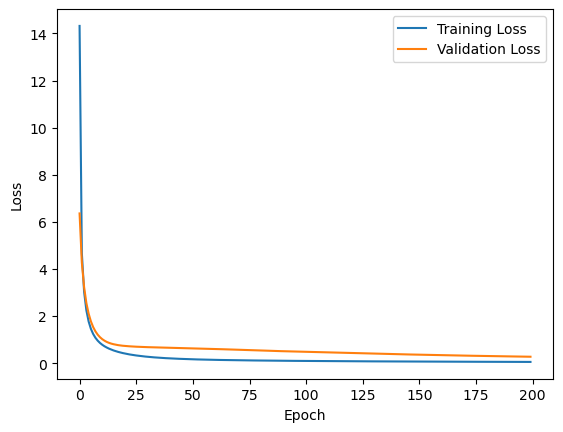

In [50]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Only contain Dense layer here!!!)
# Reshape the input data to fit Dense model
input_size = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
# Construct the model with Dense layers

model = Model()
model.add(Dense(input_size, 64))
model.add(Activation("relu", None))
model.add(Dense(64, 1))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=200, learning_rate=0.001, batch_size = 8, loss_function='mse')
### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For Dense model)
For this prediction of Dense model, you can choose not to submit it to Kaggle if its performance is not better.

In [51]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
# download
X_test_df = pd.read_csv('Sinewave/X_test.csv')
### END CODE HERE ###

# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


### Construct the model with RNN layer
Then, we can integrate our custom-built RNN layer into the model to evaluate whether it improves performance on the sequential inputs.

Epoch 1/200: 100%|██████████| 80/80 [00:01<00:00, 73.40batch/s, loss=3.59]


Epoch 1/200, Training Loss: 3.5915401798836486
Epoch 1/200, Validation Loss: 2.8929242410570826


Epoch 2/200: 100%|██████████| 80/80 [00:01<00:00, 72.79batch/s, loss=1.95]


Epoch 2/200, Training Loss: 1.9461852638916137
Epoch 2/200, Validation Loss: 1.3183834463357458


Epoch 3/200: 100%|██████████| 80/80 [00:01<00:00, 71.35batch/s, loss=0.854]


Epoch 3/200, Training Loss: 0.8542395154442927
Epoch 3/200, Validation Loss: 0.5297546615634536


Epoch 4/200: 100%|██████████| 80/80 [00:01<00:00, 72.93batch/s, loss=0.425]


Epoch 4/200, Training Loss: 0.42461284745164435
Epoch 4/200, Validation Loss: 0.3229078970399654


Epoch 5/200: 100%|██████████| 80/80 [00:01<00:00, 73.89batch/s, loss=0.325]


Epoch 5/200, Training Loss: 0.32466334745139763
Epoch 5/200, Validation Loss: 0.27970937306984567


Epoch 6/200: 100%|██████████| 80/80 [00:01<00:00, 73.72batch/s, loss=0.298]


Epoch 6/200, Training Loss: 0.29818090186945245
Epoch 6/200, Validation Loss: 0.26416429129009567


Epoch 7/200: 100%|██████████| 80/80 [00:01<00:00, 74.61batch/s, loss=0.284]


Epoch 7/200, Training Loss: 0.28353126491665953
Epoch 7/200, Validation Loss: 0.25326966776629983


Epoch 8/200: 100%|██████████| 80/80 [00:01<00:00, 72.11batch/s, loss=0.272]


Epoch 8/200, Training Loss: 0.27156634305004657
Epoch 8/200, Validation Loss: 0.24380657729284147


Epoch 9/200: 100%|██████████| 80/80 [00:01<00:00, 73.39batch/s, loss=0.261]


Epoch 9/200, Training Loss: 0.260891331469275
Epoch 9/200, Validation Loss: 0.23523524537965


Epoch 10/200: 100%|██████████| 80/80 [00:01<00:00, 74.86batch/s, loss=0.251]


Epoch 10/200, Training Loss: 0.2510613819654038
Epoch 10/200, Validation Loss: 0.22728377377118392


Epoch 11/200: 100%|██████████| 80/80 [00:01<00:00, 71.74batch/s, loss=0.242]


Epoch 11/200, Training Loss: 0.24191960551808442
Epoch 11/200, Validation Loss: 0.21989583306275606


Epoch 12/200: 100%|██████████| 80/80 [00:01<00:00, 74.72batch/s, loss=0.233]


Epoch 12/200, Training Loss: 0.23345891977385116
Epoch 12/200, Validation Loss: 0.21302207452992095


Epoch 13/200: 100%|██████████| 80/80 [00:01<00:00, 74.86batch/s, loss=0.226]


Epoch 13/200, Training Loss: 0.2256487238589573
Epoch 13/200, Validation Loss: 0.2065538508723983


Epoch 14/200: 100%|██████████| 80/80 [00:01<00:00, 73.29batch/s, loss=0.218]


Epoch 14/200, Training Loss: 0.21834769480335936
Epoch 14/200, Validation Loss: 0.20042820540815032


Epoch 15/200: 100%|██████████| 80/80 [00:01<00:00, 73.08batch/s, loss=0.211]


Epoch 15/200, Training Loss: 0.21147026953627268
Epoch 15/200, Validation Loss: 0.19461388672916335


Epoch 16/200: 100%|██████████| 80/80 [00:01<00:00, 72.04batch/s, loss=0.205]


Epoch 16/200, Training Loss: 0.20497158762376308
Epoch 16/200, Validation Loss: 0.18907630664593747


Epoch 17/200: 100%|██████████| 80/80 [00:01<00:00, 74.49batch/s, loss=0.199]


Epoch 17/200, Training Loss: 0.19877089935325123
Epoch 17/200, Validation Loss: 0.18379453051729225


Epoch 18/200: 100%|██████████| 80/80 [00:01<00:00, 73.09batch/s, loss=0.193]


Epoch 18/200, Training Loss: 0.19279772679512797
Epoch 18/200, Validation Loss: 0.17870499783449298


Epoch 19/200: 100%|██████████| 80/80 [00:01<00:00, 71.55batch/s, loss=0.187]


Epoch 19/200, Training Loss: 0.18702418428667242
Epoch 19/200, Validation Loss: 0.1736953984445637


Epoch 20/200: 100%|██████████| 80/80 [00:01<00:00, 74.25batch/s, loss=0.181]


Epoch 20/200, Training Loss: 0.18143932642551835
Epoch 20/200, Validation Loss: 0.16884750283908515


Epoch 21/200: 100%|██████████| 80/80 [00:01<00:00, 73.54batch/s, loss=0.176]


Epoch 21/200, Training Loss: 0.17599564681059104
Epoch 21/200, Validation Loss: 0.16402898400118798


Epoch 22/200: 100%|██████████| 80/80 [00:01<00:00, 73.97batch/s, loss=0.171]


Epoch 22/200, Training Loss: 0.17066088428127882
Epoch 22/200, Validation Loss: 0.15929817558237344


Epoch 23/200: 100%|██████████| 80/80 [00:01<00:00, 75.49batch/s, loss=0.166]


Epoch 23/200, Training Loss: 0.16551308549657331
Epoch 23/200, Validation Loss: 0.15470355934033034


Epoch 24/200: 100%|██████████| 80/80 [00:01<00:00, 71.29batch/s, loss=0.161]


Epoch 24/200, Training Loss: 0.16068179938667904
Epoch 24/200, Validation Loss: 0.1503249807648652


Epoch 25/200: 100%|██████████| 80/80 [00:01<00:00, 70.78batch/s, loss=0.156]


Epoch 25/200, Training Loss: 0.15610339439616613
Epoch 25/200, Validation Loss: 0.1461478391712532


Epoch 26/200: 100%|██████████| 80/80 [00:01<00:00, 73.81batch/s, loss=0.152]


Epoch 26/200, Training Loss: 0.15174843900029547
Epoch 26/200, Validation Loss: 0.1421819052771178


Epoch 27/200: 100%|██████████| 80/80 [00:01<00:00, 74.16batch/s, loss=0.148]


Epoch 27/200, Training Loss: 0.1475886365069546
Epoch 27/200, Validation Loss: 0.1383855412846759


Epoch 28/200: 100%|██████████| 80/80 [00:01<00:00, 74.12batch/s, loss=0.144]


Epoch 28/200, Training Loss: 0.14359407662296833
Epoch 28/200, Validation Loss: 0.13473649827628695


Epoch 29/200: 100%|██████████| 80/80 [00:01<00:00, 74.01batch/s, loss=0.14] 


Epoch 29/200, Training Loss: 0.13974925166670585
Epoch 29/200, Validation Loss: 0.1312158652535845


Epoch 30/200: 100%|██████████| 80/80 [00:01<00:00, 74.38batch/s, loss=0.136]


Epoch 30/200, Training Loss: 0.13602217572239883
Epoch 30/200, Validation Loss: 0.12779252994417653


Epoch 31/200: 100%|██████████| 80/80 [00:01<00:00, 71.30batch/s, loss=0.132]


Epoch 31/200, Training Loss: 0.13238497772689214
Epoch 31/200, Validation Loss: 0.12445705350265257


Epoch 32/200: 100%|██████████| 80/80 [00:01<00:00, 73.36batch/s, loss=0.129]


Epoch 32/200, Training Loss: 0.12883210238776258
Epoch 32/200, Validation Loss: 0.12119139623659297


Epoch 33/200: 100%|██████████| 80/80 [00:01<00:00, 74.68batch/s, loss=0.125]


Epoch 33/200, Training Loss: 0.12535894516940999
Epoch 33/200, Validation Loss: 0.1179967815696613


Epoch 34/200: 100%|██████████| 80/80 [00:01<00:00, 74.58batch/s, loss=0.122]


Epoch 34/200, Training Loss: 0.12194986596756663
Epoch 34/200, Validation Loss: 0.11487806700563297


Epoch 35/200: 100%|██████████| 80/80 [00:01<00:00, 74.57batch/s, loss=0.119]


Epoch 35/200, Training Loss: 0.11861151903770732
Epoch 35/200, Validation Loss: 0.11182386792882681


Epoch 36/200: 100%|██████████| 80/80 [00:01<00:00, 73.44batch/s, loss=0.115]


Epoch 36/200, Training Loss: 0.11534415948706433
Epoch 36/200, Validation Loss: 0.10885168385459375


Epoch 37/200: 100%|██████████| 80/80 [00:01<00:00, 72.80batch/s, loss=0.112]


Epoch 37/200, Training Loss: 0.11214863412340341
Epoch 37/200, Validation Loss: 0.1059446165456016


Epoch 38/200: 100%|██████████| 80/80 [00:01<00:00, 74.48batch/s, loss=0.109]


Epoch 38/200, Training Loss: 0.1090073982761796
Epoch 38/200, Validation Loss: 0.10310596477552876


Epoch 39/200: 100%|██████████| 80/80 [00:01<00:00, 76.49batch/s, loss=0.106]


Epoch 39/200, Training Loss: 0.10591757912951712
Epoch 39/200, Validation Loss: 0.10031362856051705


Epoch 40/200: 100%|██████████| 80/80 [00:01<00:00, 71.71batch/s, loss=0.103]


Epoch 40/200, Training Loss: 0.10287389983981939
Epoch 40/200, Validation Loss: 0.09757059662352377


Epoch 41/200: 100%|██████████| 80/80 [00:01<00:00, 74.26batch/s, loss=0.0999]


Epoch 41/200, Training Loss: 0.09987614260726682
Epoch 41/200, Validation Loss: 0.09486061217013766


Epoch 42/200: 100%|██████████| 80/80 [00:01<00:00, 74.79batch/s, loss=0.0969]


Epoch 42/200, Training Loss: 0.09690735734631485
Epoch 42/200, Validation Loss: 0.09215990443599656


Epoch 43/200: 100%|██████████| 80/80 [00:01<00:00, 75.17batch/s, loss=0.094] 


Epoch 43/200, Training Loss: 0.09397054223992099
Epoch 43/200, Validation Loss: 0.08950307522093577


Epoch 44/200: 100%|██████████| 80/80 [00:01<00:00, 72.50batch/s, loss=0.0911]


Epoch 44/200, Training Loss: 0.09107201516235881
Epoch 44/200, Validation Loss: 0.08685540582429248


Epoch 45/200: 100%|██████████| 80/80 [00:01<00:00, 75.34batch/s, loss=0.0882]


Epoch 45/200, Training Loss: 0.08820638567950541
Epoch 45/200, Validation Loss: 0.08424860947667484


Epoch 46/200: 100%|██████████| 80/80 [00:01<00:00, 73.43batch/s, loss=0.0854]


Epoch 46/200, Training Loss: 0.0853758952672726
Epoch 46/200, Validation Loss: 0.08168595709042166


Epoch 47/200: 100%|██████████| 80/80 [00:01<00:00, 74.95batch/s, loss=0.0826]


Epoch 47/200, Training Loss: 0.08258370719080309
Epoch 47/200, Validation Loss: 0.07916301707029913


Epoch 48/200: 100%|██████████| 80/80 [00:01<00:00, 76.80batch/s, loss=0.0798]


Epoch 48/200, Training Loss: 0.079806911966082
Epoch 48/200, Validation Loss: 0.07661880642463154


Epoch 49/200: 100%|██████████| 80/80 [00:01<00:00, 75.29batch/s, loss=0.077] 


Epoch 49/200, Training Loss: 0.07703410354581117
Epoch 49/200, Validation Loss: 0.07406985097490366


Epoch 50/200: 100%|██████████| 80/80 [00:01<00:00, 70.95batch/s, loss=0.0743]


Epoch 50/200, Training Loss: 0.074270994766186
Epoch 50/200, Validation Loss: 0.07153153596900537


Epoch 51/200: 100%|██████████| 80/80 [00:01<00:00, 74.70batch/s, loss=0.0715]


Epoch 51/200, Training Loss: 0.07153198589621139
Epoch 51/200, Validation Loss: 0.06903925282099287


Epoch 52/200: 100%|██████████| 80/80 [00:01<00:00, 72.75batch/s, loss=0.0688]


Epoch 52/200, Training Loss: 0.06884224809334168
Epoch 52/200, Validation Loss: 0.0665787080162328


Epoch 53/200: 100%|██████████| 80/80 [00:01<00:00, 74.66batch/s, loss=0.0662]


Epoch 53/200, Training Loss: 0.06617315757738336
Epoch 53/200, Validation Loss: 0.0641050522262229


Epoch 54/200: 100%|██████████| 80/80 [00:01<00:00, 75.63batch/s, loss=0.0635]


Epoch 54/200, Training Loss: 0.06348000088406366
Epoch 54/200, Validation Loss: 0.06162118581919911


Epoch 55/200: 100%|██████████| 80/80 [00:01<00:00, 73.05batch/s, loss=0.0608]


Epoch 55/200, Training Loss: 0.06080536448369027
Epoch 55/200, Validation Loss: 0.05914810653042928


Epoch 56/200: 100%|██████████| 80/80 [00:01<00:00, 73.94batch/s, loss=0.0582]


Epoch 56/200, Training Loss: 0.05817204047151946
Epoch 56/200, Validation Loss: 0.05672911455751694


Epoch 57/200: 100%|██████████| 80/80 [00:01<00:00, 75.80batch/s, loss=0.0556]


Epoch 57/200, Training Loss: 0.055588157436132934
Epoch 57/200, Validation Loss: 0.05439065950986967


Epoch 58/200: 100%|██████████| 80/80 [00:01<00:00, 73.26batch/s, loss=0.0531]


Epoch 58/200, Training Loss: 0.053075125390324426
Epoch 58/200, Validation Loss: 0.05213226613628677


Epoch 59/200: 100%|██████████| 80/80 [00:01<00:00, 76.12batch/s, loss=0.0507]


Epoch 59/200, Training Loss: 0.05065183357751015
Epoch 59/200, Validation Loss: 0.04993702959031582


Epoch 60/200: 100%|██████████| 80/80 [00:01<00:00, 75.90batch/s, loss=0.0483]


Epoch 60/200, Training Loss: 0.04833003061029629
Epoch 60/200, Validation Loss: 0.04781421515701313


Epoch 61/200: 100%|██████████| 80/80 [00:01<00:00, 69.27batch/s, loss=0.0461]


Epoch 61/200, Training Loss: 0.04610184540130909
Epoch 61/200, Validation Loss: 0.04575561278538287


Epoch 62/200: 100%|██████████| 80/80 [00:01<00:00, 69.65batch/s, loss=0.044] 


Epoch 62/200, Training Loss: 0.04396097390901759
Epoch 62/200, Validation Loss: 0.043778403787725455


Epoch 63/200: 100%|██████████| 80/80 [00:01<00:00, 62.57batch/s, loss=0.0419]


Epoch 63/200, Training Loss: 0.0419115671061915
Epoch 63/200, Validation Loss: 0.04187510421581351


Epoch 64/200: 100%|██████████| 80/80 [00:01<00:00, 62.99batch/s, loss=0.0399]


Epoch 64/200, Training Loss: 0.0399429512443336
Epoch 64/200, Validation Loss: 0.040062727189203645


Epoch 65/200: 100%|██████████| 80/80 [00:01<00:00, 65.83batch/s, loss=0.0381]


Epoch 65/200, Training Loss: 0.03805743202672897
Epoch 65/200, Validation Loss: 0.03833702540983402


Epoch 66/200: 100%|██████████| 80/80 [00:01<00:00, 66.06batch/s, loss=0.0363]


Epoch 66/200, Training Loss: 0.0362510068528145
Epoch 66/200, Validation Loss: 0.0366958413853225


Epoch 67/200: 100%|██████████| 80/80 [00:01<00:00, 43.35batch/s, loss=0.0345]


Epoch 67/200, Training Loss: 0.03452412664689471
Epoch 67/200, Validation Loss: 0.03511617296214741


Epoch 68/200: 100%|██████████| 80/80 [00:02<00:00, 31.70batch/s, loss=0.0329]


Epoch 68/200, Training Loss: 0.0328716567868065
Epoch 68/200, Validation Loss: 0.033615423713229974


Epoch 69/200: 100%|██████████| 80/80 [00:02<00:00, 32.17batch/s, loss=0.0313]


Epoch 69/200, Training Loss: 0.03129382084635017
Epoch 69/200, Validation Loss: 0.03216768183289646


Epoch 70/200: 100%|██████████| 80/80 [00:02<00:00, 32.82batch/s, loss=0.0298]


Epoch 70/200, Training Loss: 0.029787505593489742
Epoch 70/200, Validation Loss: 0.030781833001413513


Epoch 71/200: 100%|██████████| 80/80 [00:02<00:00, 31.39batch/s, loss=0.0283]


Epoch 71/200, Training Loss: 0.028347505553937762
Epoch 71/200, Validation Loss: 0.029448997759191


Epoch 72/200: 100%|██████████| 80/80 [00:02<00:00, 30.12batch/s, loss=0.027] 


Epoch 72/200, Training Loss: 0.026972822252677553
Epoch 72/200, Validation Loss: 0.028181753515931593


Epoch 73/200: 100%|██████████| 80/80 [00:02<00:00, 31.55batch/s, loss=0.0257]


Epoch 73/200, Training Loss: 0.0256623508470893
Epoch 73/200, Validation Loss: 0.026966376327182764


Epoch 74/200: 100%|██████████| 80/80 [00:02<00:00, 30.63batch/s, loss=0.0244]


Epoch 74/200, Training Loss: 0.024413072962765882
Epoch 74/200, Validation Loss: 0.025815591139068103


Epoch 75/200: 100%|██████████| 80/80 [00:02<00:00, 32.95batch/s, loss=0.0232]


Epoch 75/200, Training Loss: 0.023230147825295748
Epoch 75/200, Validation Loss: 0.02472539365803444


Epoch 76/200: 100%|██████████| 80/80 [00:02<00:00, 31.60batch/s, loss=0.0221]


Epoch 76/200, Training Loss: 0.02211194708387864
Epoch 76/200, Validation Loss: 0.023689138187584308


Epoch 77/200: 100%|██████████| 80/80 [00:02<00:00, 34.88batch/s, loss=0.0211]


Epoch 77/200, Training Loss: 0.02105235029267244
Epoch 77/200, Validation Loss: 0.022701018229859447


Epoch 78/200: 100%|██████████| 80/80 [00:02<00:00, 30.88batch/s, loss=0.02]  


Epoch 78/200, Training Loss: 0.02004243813069755
Epoch 78/200, Validation Loss: 0.02176471484279699


Epoch 79/200: 100%|██████████| 80/80 [00:02<00:00, 31.57batch/s, loss=0.0191]


Epoch 79/200, Training Loss: 0.019082248598608645
Epoch 79/200, Validation Loss: 0.020872247564426353


Epoch 80/200: 100%|██████████| 80/80 [00:02<00:00, 35.45batch/s, loss=0.0182]


Epoch 80/200, Training Loss: 0.0181701124466141
Epoch 80/200, Validation Loss: 0.02002919618322911


Epoch 81/200: 100%|██████████| 80/80 [00:01<00:00, 74.67batch/s, loss=0.0173]


Epoch 81/200, Training Loss: 0.017307160048963235
Epoch 81/200, Validation Loss: 0.019232008000877578


Epoch 82/200: 100%|██████████| 80/80 [00:01<00:00, 72.18batch/s, loss=0.0165]


Epoch 82/200, Training Loss: 0.016494676609637653
Epoch 82/200, Validation Loss: 0.0184815819640967


Epoch 83/200: 100%|██████████| 80/80 [00:01<00:00, 74.89batch/s, loss=0.0157]


Epoch 83/200, Training Loss: 0.015731502350325673
Epoch 83/200, Validation Loss: 0.017774435066124812


Epoch 84/200: 100%|██████████| 80/80 [00:01<00:00, 74.28batch/s, loss=0.015] 


Epoch 84/200, Training Loss: 0.015013830523336122
Epoch 84/200, Validation Loss: 0.017110816678211238


Epoch 85/200: 100%|██████████| 80/80 [00:01<00:00, 74.55batch/s, loss=0.0143]


Epoch 85/200, Training Loss: 0.01434008600721367
Epoch 85/200, Validation Loss: 0.016485932342335325


Epoch 86/200: 100%|██████████| 80/80 [00:01<00:00, 73.01batch/s, loss=0.0137]


Epoch 86/200, Training Loss: 0.013706171679365258
Epoch 86/200, Validation Loss: 0.015899950135108105


Epoch 87/200: 100%|██████████| 80/80 [00:01<00:00, 74.12batch/s, loss=0.0131]


Epoch 87/200, Training Loss: 0.013114535632776416
Epoch 87/200, Validation Loss: 0.015352194252148732


Epoch 88/200: 100%|██████████| 80/80 [00:01<00:00, 75.33batch/s, loss=0.0126]


Epoch 88/200, Training Loss: 0.012564633660304613
Epoch 88/200, Validation Loss: 0.014838515983651058


Epoch 89/200: 100%|██████████| 80/80 [00:01<00:00, 76.78batch/s, loss=0.0121]


Epoch 89/200, Training Loss: 0.012052734633550968
Epoch 89/200, Validation Loss: 0.014358493785859284


Epoch 90/200: 100%|██████████| 80/80 [00:01<00:00, 75.30batch/s, loss=0.0116]


Epoch 90/200, Training Loss: 0.011576615012098494
Epoch 90/200, Validation Loss: 0.013916131548706724


Epoch 91/200: 100%|██████████| 80/80 [00:01<00:00, 75.26batch/s, loss=0.0111]


Epoch 91/200, Training Loss: 0.011135175093236667
Epoch 91/200, Validation Loss: 0.013502639483809316


Epoch 92/200: 100%|██████████| 80/80 [00:01<00:00, 73.10batch/s, loss=0.0107]


Epoch 92/200, Training Loss: 0.010724730458819696
Epoch 92/200, Validation Loss: 0.01311553151447072


Epoch 93/200: 100%|██████████| 80/80 [00:01<00:00, 74.12batch/s, loss=0.0103] 


Epoch 93/200, Training Loss: 0.010342821680702094
Epoch 93/200, Validation Loss: 0.012757728899890587


Epoch 94/200: 100%|██████████| 80/80 [00:01<00:00, 73.86batch/s, loss=0.00999]


Epoch 94/200, Training Loss: 0.009990627091987784
Epoch 94/200, Validation Loss: 0.012428841194876215


Epoch 95/200: 100%|██████████| 80/80 [00:01<00:00, 73.72batch/s, loss=0.00967]


Epoch 95/200, Training Loss: 0.009666285089971405
Epoch 95/200, Validation Loss: 0.012120649184739358


Epoch 96/200: 100%|██████████| 80/80 [00:01<00:00, 75.12batch/s, loss=0.00937]


Epoch 96/200, Training Loss: 0.009366514911714481
Epoch 96/200, Validation Loss: 0.011830487106506


Epoch 97/200: 100%|██████████| 80/80 [00:01<00:00, 75.20batch/s, loss=0.00909]


Epoch 97/200, Training Loss: 0.009088391038736298
Epoch 97/200, Validation Loss: 0.011562594041603192


Epoch 98/200: 100%|██████████| 80/80 [00:01<00:00, 73.23batch/s, loss=0.00883]


Epoch 98/200, Training Loss: 0.0088324461094303
Epoch 98/200, Validation Loss: 0.011316884472830718


Epoch 99/200: 100%|██████████| 80/80 [00:01<00:00, 75.29batch/s, loss=0.0086] 


Epoch 99/200, Training Loss: 0.008596313270520801
Epoch 99/200, Validation Loss: 0.011088320859409407


Epoch 100/200: 100%|██████████| 80/80 [00:01<00:00, 74.15batch/s, loss=0.00838]


Epoch 100/200, Training Loss: 0.008379416265073237
Epoch 100/200, Validation Loss: 0.010874995132471539


Epoch 101/200: 100%|██████████| 80/80 [00:01<00:00, 72.96batch/s, loss=0.00818]


Epoch 101/200, Training Loss: 0.008177077918061533
Epoch 101/200, Validation Loss: 0.010675412475001669


Epoch 102/200: 100%|██████████| 80/80 [00:01<00:00, 74.89batch/s, loss=0.00799]


Epoch 102/200, Training Loss: 0.007990547726138778
Epoch 102/200, Validation Loss: 0.010491293310427528


Epoch 103/200: 100%|██████████| 80/80 [00:01<00:00, 75.06batch/s, loss=0.00782]


Epoch 103/200, Training Loss: 0.007819452739185839
Epoch 103/200, Validation Loss: 0.010322008133175563


Epoch 104/200: 100%|██████████| 80/80 [00:01<00:00, 73.49batch/s, loss=0.00766]


Epoch 104/200, Training Loss: 0.0076623146312632204
Epoch 104/200, Validation Loss: 0.010165066075075842


Epoch 105/200: 100%|██████████| 80/80 [00:01<00:00, 74.89batch/s, loss=0.00752]


Epoch 105/200, Training Loss: 0.007518137524453487
Epoch 105/200, Validation Loss: 0.010018693407339196


Epoch 106/200: 100%|██████████| 80/80 [00:01<00:00, 76.30batch/s, loss=0.00738]


Epoch 106/200, Training Loss: 0.007383924292063361
Epoch 106/200, Validation Loss: 0.009881790634417194


Epoch 107/200: 100%|██████████| 80/80 [00:01<00:00, 73.98batch/s, loss=0.00726]


Epoch 107/200, Training Loss: 0.007260307775396481
Epoch 107/200, Validation Loss: 0.009751935078656956


Epoch 108/200: 100%|██████████| 80/80 [00:01<00:00, 74.61batch/s, loss=0.00715]


Epoch 108/200, Training Loss: 0.0071459693710103495
Epoch 108/200, Validation Loss: 0.009631450950229069


Epoch 109/200: 100%|██████████| 80/80 [00:01<00:00, 70.06batch/s, loss=0.00704]


Epoch 109/200, Training Loss: 0.00704084185075903
Epoch 109/200, Validation Loss: 0.009518783473207277


Epoch 110/200: 100%|██████████| 80/80 [00:01<00:00, 72.74batch/s, loss=0.00694]


Epoch 110/200, Training Loss: 0.006943812580703137
Epoch 110/200, Validation Loss: 0.009413704091916806


Epoch 111/200: 100%|██████████| 80/80 [00:01<00:00, 76.01batch/s, loss=0.00685]


Epoch 111/200, Training Loss: 0.006854134881267475
Epoch 111/200, Validation Loss: 0.00931590239591288


Epoch 112/200: 100%|██████████| 80/80 [00:01<00:00, 75.33batch/s, loss=0.00677]


Epoch 112/200, Training Loss: 0.0067709159181359255
Epoch 112/200, Validation Loss: 0.009225457263020445


Epoch 113/200: 100%|██████████| 80/80 [00:01<00:00, 74.25batch/s, loss=0.00669]


Epoch 113/200, Training Loss: 0.0066940995376867565
Epoch 113/200, Validation Loss: 0.00914069817300095


Epoch 114/200: 100%|██████████| 80/80 [00:01<00:00, 71.97batch/s, loss=0.00662]


Epoch 114/200, Training Loss: 0.006622619147287042
Epoch 114/200, Validation Loss: 0.00906105012963247


Epoch 115/200: 100%|██████████| 80/80 [00:01<00:00, 72.04batch/s, loss=0.00656]


Epoch 115/200, Training Loss: 0.006555794705369723
Epoch 115/200, Validation Loss: 0.008985427951836863


Epoch 116/200: 100%|██████████| 80/80 [00:01<00:00, 73.55batch/s, loss=0.00649]


Epoch 116/200, Training Loss: 0.0064932487493211885
Epoch 116/200, Validation Loss: 0.008914362302305285


Epoch 117/200: 100%|██████████| 80/80 [00:01<00:00, 74.93batch/s, loss=0.00643]


Epoch 117/200, Training Loss: 0.006434554365447473
Epoch 117/200, Validation Loss: 0.00884675301466492


Epoch 118/200: 100%|██████████| 80/80 [00:01<00:00, 74.69batch/s, loss=0.00638]


Epoch 118/200, Training Loss: 0.006379461497727959
Epoch 118/200, Validation Loss: 0.008782698949898079


Epoch 119/200: 100%|██████████| 80/80 [00:01<00:00, 73.55batch/s, loss=0.00633]


Epoch 119/200, Training Loss: 0.006327488703500074
Epoch 119/200, Validation Loss: 0.008722473553825816


Epoch 120/200: 100%|██████████| 80/80 [00:01<00:00, 72.55batch/s, loss=0.00628]


Epoch 120/200, Training Loss: 0.006278236881877978
Epoch 120/200, Validation Loss: 0.008662144632083762


Epoch 121/200: 100%|██████████| 80/80 [00:01<00:00, 72.72batch/s, loss=0.00623]


Epoch 121/200, Training Loss: 0.006230528602380609
Epoch 121/200, Validation Loss: 0.008607797736624989


Epoch 122/200: 100%|██████████| 80/80 [00:01<00:00, 73.87batch/s, loss=0.00619]


Epoch 122/200, Training Loss: 0.006185151010198056
Epoch 122/200, Validation Loss: 0.008556537953231807


Epoch 123/200: 100%|██████████| 80/80 [00:01<00:00, 75.35batch/s, loss=0.00614]


Epoch 123/200, Training Loss: 0.0061421135278220546
Epoch 123/200, Validation Loss: 0.008505565553261239


Epoch 124/200: 100%|██████████| 80/80 [00:01<00:00, 74.90batch/s, loss=0.0061] 


Epoch 124/200, Training Loss: 0.006101059221420164
Epoch 124/200, Validation Loss: 0.008458264729380821


Epoch 125/200: 100%|██████████| 80/80 [00:01<00:00, 74.31batch/s, loss=0.00606]


Epoch 125/200, Training Loss: 0.006061871904203682
Epoch 125/200, Validation Loss: 0.008409988706019148


Epoch 126/200: 100%|██████████| 80/80 [00:01<00:00, 73.40batch/s, loss=0.00602]


Epoch 126/200, Training Loss: 0.006024431120809871
Epoch 126/200, Validation Loss: 0.008363955538111728


Epoch 127/200: 100%|██████████| 80/80 [00:01<00:00, 71.44batch/s, loss=0.00599]


Epoch 127/200, Training Loss: 0.005988634813256845
Epoch 127/200, Validation Loss: 0.008320727753540206


Epoch 128/200: 100%|██████████| 80/80 [00:01<00:00, 73.94batch/s, loss=0.00595]


Epoch 128/200, Training Loss: 0.005954236534050096
Epoch 128/200, Validation Loss: 0.008279051167835519


Epoch 129/200: 100%|██████████| 80/80 [00:01<00:00, 73.89batch/s, loss=0.00592]


Epoch 129/200, Training Loss: 0.005921049939116492
Epoch 129/200, Validation Loss: 0.008238181402049457


Epoch 130/200: 100%|██████████| 80/80 [00:01<00:00, 73.39batch/s, loss=0.00589]


Epoch 130/200, Training Loss: 0.0058889224081847364
Epoch 130/200, Validation Loss: 0.008196076026792596


Epoch 131/200: 100%|██████████| 80/80 [00:01<00:00, 68.66batch/s, loss=0.00586]


Epoch 131/200, Training Loss: 0.005858156063369818
Epoch 131/200, Validation Loss: 0.008156407123311268


Epoch 132/200: 100%|██████████| 80/80 [00:01<00:00, 61.29batch/s, loss=0.00583]


Epoch 132/200, Training Loss: 0.005828314763450716
Epoch 132/200, Validation Loss: 0.008118750096163726


Epoch 133/200: 100%|██████████| 80/80 [00:01<00:00, 60.67batch/s, loss=0.0058] 


Epoch 133/200, Training Loss: 0.005799264078909751
Epoch 133/200, Validation Loss: 0.008081765360487403


Epoch 134/200: 100%|██████████| 80/80 [00:01<00:00, 75.40batch/s, loss=0.00577]


Epoch 134/200, Training Loss: 0.005771066852634126
Epoch 134/200, Validation Loss: 0.008046237198816928


Epoch 135/200: 100%|██████████| 80/80 [00:01<00:00, 76.44batch/s, loss=0.00574]


Epoch 135/200, Training Loss: 0.005743570953765967
Epoch 135/200, Validation Loss: 0.008011899985724998


Epoch 136/200: 100%|██████████| 80/80 [00:01<00:00, 75.69batch/s, loss=0.00572]


Epoch 136/200, Training Loss: 0.005716760993615641
Epoch 136/200, Validation Loss: 0.007977794152513113


Epoch 137/200: 100%|██████████| 80/80 [00:01<00:00, 74.45batch/s, loss=0.00569]


Epoch 137/200, Training Loss: 0.0056905659818123734
Epoch 137/200, Validation Loss: 0.007944716641909672


Epoch 138/200: 100%|██████████| 80/80 [00:01<00:00, 75.03batch/s, loss=0.00566]


Epoch 138/200, Training Loss: 0.00566494594694605
Epoch 138/200, Validation Loss: 0.007910186036633881


Epoch 139/200: 100%|██████████| 80/80 [00:01<00:00, 74.02batch/s, loss=0.00564]


Epoch 139/200, Training Loss: 0.005639885859523245
Epoch 139/200, Validation Loss: 0.00787807135046927


Epoch 140/200: 100%|██████████| 80/80 [00:01<00:00, 75.16batch/s, loss=0.00562]


Epoch 140/200, Training Loss: 0.0056153532592664954
Epoch 140/200, Validation Loss: 0.007846678270310914


Epoch 141/200: 100%|██████████| 80/80 [00:01<00:00, 76.23batch/s, loss=0.00559]


Epoch 141/200, Training Loss: 0.005591487749705597
Epoch 141/200, Validation Loss: 0.007814231286377775


Epoch 142/200: 100%|██████████| 80/80 [00:01<00:00, 74.92batch/s, loss=0.00557]


Epoch 142/200, Training Loss: 0.00556805799619313
Epoch 142/200, Validation Loss: 0.007784204603265038


Epoch 143/200: 100%|██████████| 80/80 [00:01<00:00, 74.77batch/s, loss=0.00555]


Epoch 143/200, Training Loss: 0.005545061687317795
Epoch 143/200, Validation Loss: 0.007754876520463927


Epoch 144/200: 100%|██████████| 80/80 [00:01<00:00, 74.34batch/s, loss=0.00552]


Epoch 144/200, Training Loss: 0.005522480820286996
Epoch 144/200, Validation Loss: 0.007725783684473346


Epoch 145/200: 100%|██████████| 80/80 [00:01<00:00, 73.77batch/s, loss=0.0055] 


Epoch 145/200, Training Loss: 0.005500220786036104
Epoch 145/200, Validation Loss: 0.00769705678232132


Epoch 146/200: 100%|██████████| 80/80 [00:01<00:00, 73.75batch/s, loss=0.00548]


Epoch 146/200, Training Loss: 0.005478252363796654
Epoch 146/200, Validation Loss: 0.007668832780353705


Epoch 147/200: 100%|██████████| 80/80 [00:01<00:00, 72.31batch/s, loss=0.00546]


Epoch 147/200, Training Loss: 0.005456699239613734
Epoch 147/200, Validation Loss: 0.007640946321723028


Epoch 148/200: 100%|██████████| 80/80 [00:01<00:00, 72.92batch/s, loss=0.00544]


Epoch 148/200, Training Loss: 0.005435513145793486
Epoch 148/200, Validation Loss: 0.0076132782218447555


Epoch 149/200: 100%|██████████| 80/80 [00:01<00:00, 75.25batch/s, loss=0.00541]


Epoch 149/200, Training Loss: 0.005414673819266672
Epoch 149/200, Validation Loss: 0.007586260028454941


Epoch 150/200: 100%|██████████| 80/80 [00:01<00:00, 74.99batch/s, loss=0.00539]


Epoch 150/200, Training Loss: 0.0053942005108560094
Epoch 150/200, Validation Loss: 0.007559305024388708


Epoch 151/200: 100%|██████████| 80/80 [00:01<00:00, 68.30batch/s, loss=0.00537]


Epoch 151/200, Training Loss: 0.0053742039196284655
Epoch 151/200, Validation Loss: 0.007532234409439321


Epoch 152/200: 100%|██████████| 80/80 [00:01<00:00, 76.69batch/s, loss=0.00535]


Epoch 152/200, Training Loss: 0.0053542781192845255
Epoch 152/200, Validation Loss: 0.0075060089626851545


Epoch 153/200: 100%|██████████| 80/80 [00:01<00:00, 78.13batch/s, loss=0.00533]


Epoch 153/200, Training Loss: 0.005334716812808716
Epoch 153/200, Validation Loss: 0.007480051322288435


Epoch 154/200: 100%|██████████| 80/80 [00:01<00:00, 75.44batch/s, loss=0.00532]


Epoch 154/200, Training Loss: 0.005315442119252312
Epoch 154/200, Validation Loss: 0.007454352150140533


Epoch 155/200: 100%|██████████| 80/80 [00:01<00:00, 71.93batch/s, loss=0.0053] 


Epoch 155/200, Training Loss: 0.00529638619471432
Epoch 155/200, Validation Loss: 0.0074290359792059685


Epoch 156/200: 100%|██████████| 80/80 [00:01<00:00, 73.20batch/s, loss=0.00528]


Epoch 156/200, Training Loss: 0.005277570402087199
Epoch 156/200, Validation Loss: 0.007402880905962789


Epoch 157/200: 100%|██████████| 80/80 [00:01<00:00, 75.30batch/s, loss=0.00526]


Epoch 157/200, Training Loss: 0.005259366604620832
Epoch 157/200, Validation Loss: 0.007375922360337937


Epoch 158/200: 100%|██████████| 80/80 [00:01<00:00, 75.09batch/s, loss=0.00524]


Epoch 158/200, Training Loss: 0.00524122145423993
Epoch 158/200, Validation Loss: 0.007351222086341443


Epoch 159/200: 100%|██████████| 80/80 [00:01<00:00, 75.39batch/s, loss=0.00522]


Epoch 159/200, Training Loss: 0.005223341828721904
Epoch 159/200, Validation Loss: 0.007327573332167788


Epoch 160/200: 100%|██████████| 80/80 [00:01<00:00, 75.43batch/s, loss=0.00521]


Epoch 160/200, Training Loss: 0.005206167706206648
Epoch 160/200, Validation Loss: 0.007297279303757152


Epoch 161/200: 100%|██████████| 80/80 [00:01<00:00, 74.47batch/s, loss=0.00519]


Epoch 161/200, Training Loss: 0.005188632105058229
Epoch 161/200, Validation Loss: 0.007273208395792883


Epoch 162/200: 100%|██████████| 80/80 [00:01<00:00, 72.39batch/s, loss=0.00517]


Epoch 162/200, Training Loss: 0.0051714955846734
Epoch 162/200, Validation Loss: 0.0072502515517415865


Epoch 163/200: 100%|██████████| 80/80 [00:01<00:00, 74.19batch/s, loss=0.00515]


Epoch 163/200, Training Loss: 0.005154454615360756
Epoch 163/200, Validation Loss: 0.00722712012248114


Epoch 164/200: 100%|██████████| 80/80 [00:01<00:00, 75.26batch/s, loss=0.00514]


Epoch 164/200, Training Loss: 0.005137534646794045
Epoch 164/200, Validation Loss: 0.007204458641473193


Epoch 165/200: 100%|██████████| 80/80 [00:01<00:00, 76.64batch/s, loss=0.00512]


Epoch 165/200, Training Loss: 0.00512078688748586
Epoch 165/200, Validation Loss: 0.007181703928133586


Epoch 166/200: 100%|██████████| 80/80 [00:01<00:00, 75.70batch/s, loss=0.0051] 


Epoch 166/200, Training Loss: 0.005104265309958262
Epoch 166/200, Validation Loss: 0.00715948332564602


Epoch 167/200: 100%|██████████| 80/80 [00:01<00:00, 72.93batch/s, loss=0.00509]


Epoch 167/200, Training Loss: 0.005087867894318952
Epoch 167/200, Validation Loss: 0.0071376570842051805


Epoch 168/200: 100%|██████████| 80/80 [00:01<00:00, 70.10batch/s, loss=0.00507]


Epoch 168/200, Training Loss: 0.005071703363903625
Epoch 168/200, Validation Loss: 0.007115746196973508


Epoch 169/200: 100%|██████████| 80/80 [00:01<00:00, 70.32batch/s, loss=0.00506]


Epoch 169/200, Training Loss: 0.005055684462506572
Epoch 169/200, Validation Loss: 0.007094146344722984


Epoch 170/200: 100%|██████████| 80/80 [00:01<00:00, 75.86batch/s, loss=0.00504]


Epoch 170/200, Training Loss: 0.005039830113059711
Epoch 170/200, Validation Loss: 0.0070719520858702496


Epoch 171/200: 100%|██████████| 80/80 [00:01<00:00, 74.71batch/s, loss=0.00502]


Epoch 171/200, Training Loss: 0.005024024128416341
Epoch 171/200, Validation Loss: 0.0070505637387595355


Epoch 172/200: 100%|██████████| 80/80 [00:01<00:00, 74.40batch/s, loss=0.00501]


Epoch 172/200, Training Loss: 0.0050083464789464
Epoch 172/200, Validation Loss: 0.007029706831945079


Epoch 173/200: 100%|██████████| 80/80 [00:01<00:00, 75.08batch/s, loss=0.00499]


Epoch 173/200, Training Loss: 0.004992809130011565
Epoch 173/200, Validation Loss: 0.007008724789987763


Epoch 174/200: 100%|██████████| 80/80 [00:01<00:00, 71.32batch/s, loss=0.00498]


Epoch 174/200, Training Loss: 0.004977585840749536
Epoch 174/200, Validation Loss: 0.006987597677487936


Epoch 175/200: 100%|██████████| 80/80 [00:01<00:00, 76.56batch/s, loss=0.00496]


Epoch 175/200, Training Loss: 0.004962513647800803
Epoch 175/200, Validation Loss: 0.00696742031666224


Epoch 176/200: 100%|██████████| 80/80 [00:01<00:00, 76.96batch/s, loss=0.00495]


Epoch 176/200, Training Loss: 0.004947581570054366
Epoch 176/200, Validation Loss: 0.006947125382152386


Epoch 177/200: 100%|██████████| 80/80 [00:01<00:00, 76.28batch/s, loss=0.00493]


Epoch 177/200, Training Loss: 0.0049327924712824125
Epoch 177/200, Validation Loss: 0.006927100546597873


Epoch 178/200: 100%|██████████| 80/80 [00:01<00:00, 73.84batch/s, loss=0.00492]


Epoch 178/200, Training Loss: 0.0049180916895644675
Epoch 178/200, Validation Loss: 0.006907461590464932


Epoch 179/200: 100%|██████████| 80/80 [00:01<00:00, 74.35batch/s, loss=0.0049] 


Epoch 179/200, Training Loss: 0.004903461323424949
Epoch 179/200, Validation Loss: 0.006887593305996396


Epoch 180/200: 100%|██████████| 80/80 [00:01<00:00, 73.85batch/s, loss=0.00489]


Epoch 180/200, Training Loss: 0.004888976243846913
Epoch 180/200, Validation Loss: 0.006868100409696533


Epoch 181/200: 100%|██████████| 80/80 [00:01<00:00, 75.30batch/s, loss=0.00487]


Epoch 181/200, Training Loss: 0.0048746459420887615
Epoch 181/200, Validation Loss: 0.006848823437504252


Epoch 182/200: 100%|██████████| 80/80 [00:01<00:00, 74.54batch/s, loss=0.00486]


Epoch 182/200, Training Loss: 0.004860421618623365
Epoch 182/200, Validation Loss: 0.006829510845071858


Epoch 183/200: 100%|██████████| 80/80 [00:01<00:00, 74.20batch/s, loss=0.00485]


Epoch 183/200, Training Loss: 0.00484645084395828
Epoch 183/200, Validation Loss: 0.006809081269012674


Epoch 184/200: 100%|██████████| 80/80 [00:01<00:00, 75.58batch/s, loss=0.00483]


Epoch 184/200, Training Loss: 0.004832562857980794
Epoch 184/200, Validation Loss: 0.006790014920167717


Epoch 185/200: 100%|██████████| 80/80 [00:01<00:00, 77.00batch/s, loss=0.00482]


Epoch 185/200, Training Loss: 0.004818787787422029
Epoch 185/200, Validation Loss: 0.006770885133829414


Epoch 186/200: 100%|██████████| 80/80 [00:01<00:00, 73.72batch/s, loss=0.00481]


Epoch 186/200, Training Loss: 0.00480514598780491
Epoch 186/200, Validation Loss: 0.006752200664997755


Epoch 187/200: 100%|██████████| 80/80 [00:01<00:00, 71.92batch/s, loss=0.00479]


Epoch 187/200, Training Loss: 0.004791589091746059
Epoch 187/200, Validation Loss: 0.006733388530409764


Epoch 188/200: 100%|██████████| 80/80 [00:01<00:00, 71.25batch/s, loss=0.00478]


Epoch 188/200, Training Loss: 0.004778156222238815
Epoch 188/200, Validation Loss: 0.006715061984565941


Epoch 189/200: 100%|██████████| 80/80 [00:01<00:00, 73.60batch/s, loss=0.00476]


Epoch 189/200, Training Loss: 0.004764784347211224
Epoch 189/200, Validation Loss: 0.006696553668792699


Epoch 190/200: 100%|██████████| 80/80 [00:01<00:00, 74.05batch/s, loss=0.00475]


Epoch 190/200, Training Loss: 0.004751533763849658
Epoch 190/200, Validation Loss: 0.006678427121476181


Epoch 191/200: 100%|██████████| 80/80 [00:01<00:00, 76.42batch/s, loss=0.00474]


Epoch 191/200, Training Loss: 0.004738370671708193
Epoch 191/200, Validation Loss: 0.00666015215095562


Epoch 192/200: 100%|██████████| 80/80 [00:01<00:00, 71.75batch/s, loss=0.00473]


Epoch 192/200, Training Loss: 0.004725368172313025
Epoch 192/200, Validation Loss: 0.006641935496534412


Epoch 193/200: 100%|██████████| 80/80 [00:01<00:00, 72.20batch/s, loss=0.00471]


Epoch 193/200, Training Loss: 0.004712415623252684
Epoch 193/200, Validation Loss: 0.006623997880889346


Epoch 194/200: 100%|██████████| 80/80 [00:01<00:00, 76.17batch/s, loss=0.0047] 


Epoch 194/200, Training Loss: 0.0046994796744970185
Epoch 194/200, Validation Loss: 0.006605432387774852


Epoch 195/200: 100%|██████████| 80/80 [00:01<00:00, 74.24batch/s, loss=0.00469]


Epoch 195/200, Training Loss: 0.004686589424982073
Epoch 195/200, Validation Loss: 0.006587367525956268


Epoch 196/200: 100%|██████████| 80/80 [00:01<00:00, 73.69batch/s, loss=0.00467]


Epoch 196/200, Training Loss: 0.004673755582161961
Epoch 196/200, Validation Loss: 0.0065696188090073925


Epoch 197/200: 100%|██████████| 80/80 [00:01<00:00, 73.25batch/s, loss=0.00466]


Epoch 197/200, Training Loss: 0.0046610676281038325
Epoch 197/200, Validation Loss: 0.006552245209253126


Epoch 198/200: 100%|██████████| 80/80 [00:01<00:00, 73.69batch/s, loss=0.00465]


Epoch 198/200, Training Loss: 0.004648416444938647
Epoch 198/200, Validation Loss: 0.006534414285852232


Epoch 199/200: 100%|██████████| 80/80 [00:01<00:00, 73.80batch/s, loss=0.00464]


Epoch 199/200, Training Loss: 0.004635931930891314
Epoch 199/200, Validation Loss: 0.006517481578952655


Epoch 200/200: 100%|██████████| 80/80 [00:01<00:00, 74.41batch/s, loss=0.00462]


Epoch 200/200, Training Loss: 0.004623638880855058
Epoch 200/200, Validation Loss: 0.0065004693739193296


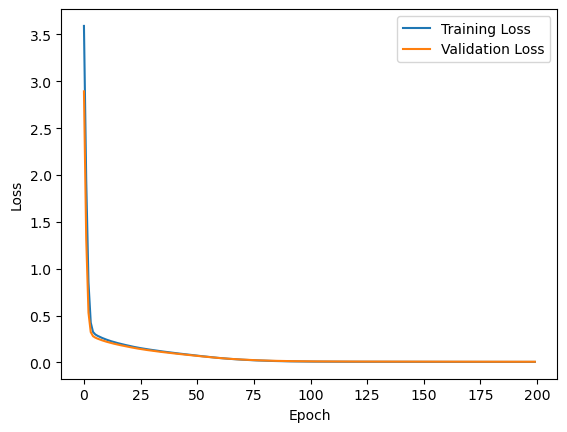

In [66]:
### START CODE HERE ###
# Change the structure and parameters to train your own model (Can add RNN layer here)
# Reshape X_train and X_val to fit the RNN layer input shape.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_val = y_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# Construct the model & Set the parameters.
input_size = 1  # Number of input features (1 for single sine wave value)
rnn_units = 64  # Number of units in the RNN layer  # 32
dense_units = 32  # Number of units in the Dense layer  # 16
output_size = 1  # Number of output classes (1 for single sine wave value)

model = Model()
model.add(RNN(input_size, rnn_units))
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, output_size))
model.add(Activation("linear", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=200, learning_rate=0.01, batch_size = 16, loss_function='mse')  # 16
### END CODE HERE ###

# Plot the training and validation losses
model.plot_losses()

#### Predict testing data & Save the answer (For RNN model)
Remember to submit your prediction to Kaggle!

In [67]:
### START CODE HERE ###
# Read the X_test.csv file into a DataFrame
# Change the path if needed
X_test_df = pd.read_csv('Sinewave/X_test.csv')
### END CODE HERE ###


# Do not modify this part to get the correct output format!!
# Drop the 'Id' column if it exists
if 'Id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['Id'])

# Convert the DataFrame to a numpy array
X_test = X_test_df.values
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # reshape the X_test to fit RNN layer input shape.
y_pred = model.predict(X_test)


# Convert the list of predictions to a numpy array
y_pred = np.array(y_pred)
y_pred_df = pd.DataFrame(y_pred, columns=['answer'])
y_pred_df.insert(0, 'Id', range(1, 1 + len(y_pred_df)))
y_pred_df.to_csv('y_pred_basic.csv', index=False)

print('Prediction data has been saved.')

Prediction data has been saved.


# Advance part (35%)






## Accelerometer and Gyroscope dataset
- ⚠⚠ You need to download the training & testing data from Kaggle. ⚠⚠ (Put it into the directory name `Activity data`, or your need to change the path in template.)
- In this dataset, we provide the time-series Accelerometer and Gyroscope data each with 3-axial (x, y, z) (total 6 channels).
- We classified the activity into 3 different classes:
    Activity 1, 2, 3\
    You have to build a RNN model using these time-series data to predict the activity class.
- Steps:
    1. Load the provided `X_train.npy`, `y_train.npy` and `X_test.npy` and split the part of training data to validation.\
    Note: `y_train.npy` is already one-hot encoded.
    2. Visualize the `X_train.npy`.
    3. One-hot encode the `y_train.npy` for three classes: Activity 1, Activity 2, Activity 3.
    4. Build your own RNN model and train it.
    5. Predict with the `X_test.npy` and generate `y_test.csv` then **submit it to Kaggle**!
- We have set 3 baselines on public score:
    * Accuracy >= 0.65 -> 10 points
    * Accuracy >= 0.7  -> 20 points
    * Accuracy >= 0.75 -> 25 points
- Kaggle link: https://www.kaggle.com/t/95e0b11f63e74566802b0dea5ec4f1b4


### 1. Load training & testing data
Load the training and testing data, then split the training data into a validation set using your preferred ratio.

In [122]:
### START CODE HERE ###
# Load X_train, y_train and X_test data
# Change the path if needed
y_train = np.load('Activity data/y_train.npy')
X_train = np.load('Activity data/X_train.npy')
X_test = np.load('Activity data/X_test.npy')
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
### END CODE HERE ###

### START CODE HERE ###
# Define the validation ratio in your preferred way
# 1. One-hot encode y_train. (3 classes)
# 2. Split the X_train, y_train data into train & validation set.
validation_ratio = 0.15

y_train = np.eye(3)[y_train.reshape(-1)]

split_idx = int((1 - validation_ratio) * X_train.shape[0])
X_train, X_val = X_train[:split_idx], X_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]

# print(f"Training data shape: {X_train.shape}, {y_train.shape}")
# print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
### END CODE HERE ###



X_train shape: (7352, 128, 6)
y_train shape: (7352, 1)
X_test shape: (2947, 128, 6)


### 2. Visualize the training data

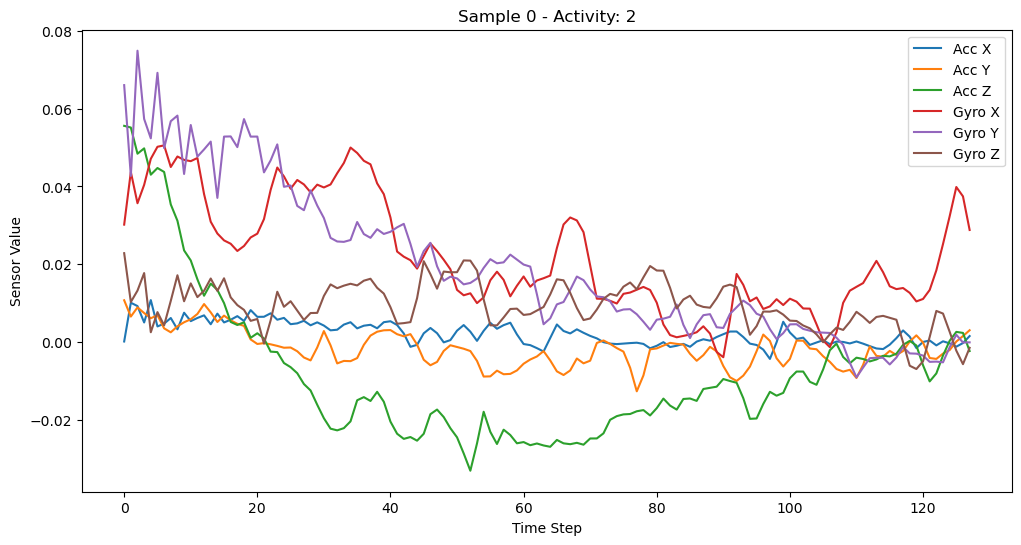

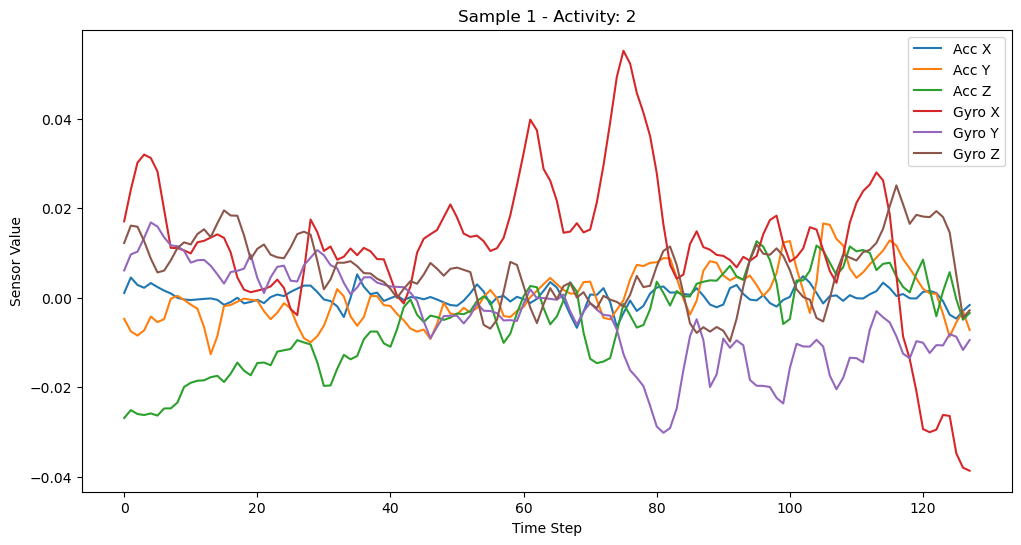

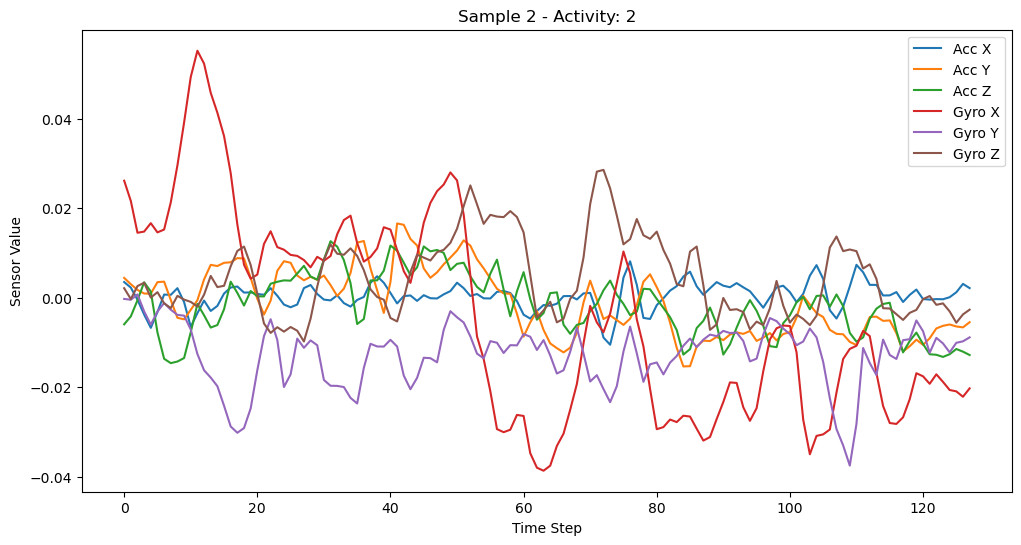

In [104]:
# Function to plot a single sample
def plot_sample(X, y, sample_index):
    plt.figure(figsize=(12, 6))
    plt.plot(X[sample_index, :, 0], label='Acc X')
    plt.plot(X[sample_index, :, 1], label='Acc Y')
    plt.plot(X[sample_index, :, 2], label='Acc Z')
    plt.plot(X[sample_index, :, 3], label='Gyro X')
    plt.plot(X[sample_index, :, 4], label='Gyro Y')
    plt.plot(X[sample_index, :, 5], label='Gyro Z')
    plt.title(f'Sample {sample_index} - Activity: {np.argmax(y[sample_index])}')
    plt.xlabel('Time Step')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

### START CODE HERE ###
# Plot a few samples
for i in range(3):              # Change the range to visualize more samples
    plot_sample(X_train, y_train, i)
 ### END CODE HERE ###

### 3. Contruct and train the model

Epoch 1/35: 100%|██████████| 195/195 [00:09<00:00, 21.25batch/s, loss=0.991]


Epoch 1/35, Training Loss: 0.9902576823555949
Epoch 1/35, Validation Loss: 0.9280518836564607


Epoch 2/35: 100%|██████████| 195/195 [00:09<00:00, 21.33batch/s, loss=0.878]


Epoch 2/35, Training Loss: 0.8763723544978469
Epoch 2/35, Validation Loss: 0.7362351202623791


Epoch 3/35: 100%|██████████| 195/195 [00:09<00:00, 21.64batch/s, loss=0.634]


Epoch 3/35, Training Loss: 0.6335467194450634
Epoch 3/35, Validation Loss: 0.5666024937408317


Epoch 4/35: 100%|██████████| 195/195 [00:08<00:00, 21.71batch/s, loss=0.543]


Epoch 4/35, Training Loss: 0.542425854316461
Epoch 4/35, Validation Loss: 0.49098989122673914


Epoch 5/35: 100%|██████████| 195/195 [00:09<00:00, 21.62batch/s, loss=0.485]


Epoch 5/35, Training Loss: 0.48474235503191526
Epoch 5/35, Validation Loss: 0.451904095702531


Epoch 6/35: 100%|██████████| 195/195 [00:08<00:00, 22.10batch/s, loss=0.461]


Epoch 6/35, Training Loss: 0.46161991960434245
Epoch 6/35, Validation Loss: 0.4478378998656823


Epoch 7/35: 100%|██████████| 195/195 [00:09<00:00, 21.35batch/s, loss=0.45] 


Epoch 7/35, Training Loss: 0.45083046983787434
Epoch 7/35, Validation Loss: 0.4432484175985493


Epoch 8/35: 100%|██████████| 195/195 [00:09<00:00, 21.53batch/s, loss=0.44] 


Epoch 8/35, Training Loss: 0.44031090245742155
Epoch 8/35, Validation Loss: 0.426894782697858


Epoch 9/35: 100%|██████████| 195/195 [00:08<00:00, 21.85batch/s, loss=0.427]


Epoch 9/35, Training Loss: 0.4270680174101885
Epoch 9/35, Validation Loss: 0.40940900295282595


Epoch 10/35: 100%|██████████| 195/195 [00:08<00:00, 21.73batch/s, loss=0.413]


Epoch 10/35, Training Loss: 0.4127829778021458
Epoch 10/35, Validation Loss: 0.3948805237247023


Epoch 11/35: 100%|██████████| 195/195 [00:08<00:00, 21.74batch/s, loss=0.4]  


Epoch 11/35, Training Loss: 0.39913001321583363
Epoch 11/35, Validation Loss: 0.38551508233128096


Epoch 12/35: 100%|██████████| 195/195 [00:08<00:00, 22.07batch/s, loss=0.388]


Epoch 12/35, Training Loss: 0.3873071825858955
Epoch 12/35, Validation Loss: 0.3758984801259725


Epoch 13/35: 100%|██████████| 195/195 [00:08<00:00, 21.72batch/s, loss=0.378]


Epoch 13/35, Training Loss: 0.37763796788657084
Epoch 13/35, Validation Loss: 0.3670903010489425


Epoch 14/35: 100%|██████████| 195/195 [00:08<00:00, 21.85batch/s, loss=0.37] 


Epoch 14/35, Training Loss: 0.36968952841823177
Epoch 14/35, Validation Loss: 0.36021999627680673


Epoch 15/35: 100%|██████████| 195/195 [00:08<00:00, 21.90batch/s, loss=0.363]


Epoch 15/35, Training Loss: 0.3627568696573218
Epoch 15/35, Validation Loss: 0.353807766923298


Epoch 16/35: 100%|██████████| 195/195 [00:08<00:00, 22.14batch/s, loss=0.358]


Epoch 16/35, Training Loss: 0.3573681476966131
Epoch 16/35, Validation Loss: 0.34752117263060167


Epoch 17/35: 100%|██████████| 195/195 [00:09<00:00, 21.51batch/s, loss=0.353]


Epoch 17/35, Training Loss: 0.35295832846721475
Epoch 17/35, Validation Loss: 0.3378435118007974


Epoch 18/35: 100%|██████████| 195/195 [00:08<00:00, 22.06batch/s, loss=0.35] 


Epoch 18/35, Training Loss: 0.34865789671852176
Epoch 18/35, Validation Loss: 0.3679289983836031


Epoch 19/35: 100%|██████████| 195/195 [00:08<00:00, 21.74batch/s, loss=0.344]


Epoch 19/35, Training Loss: 0.34291451611914586
Epoch 19/35, Validation Loss: 0.34261286442226224


Epoch 20/35: 100%|██████████| 195/195 [00:08<00:00, 21.77batch/s, loss=0.336]


Epoch 20/35, Training Loss: 0.33487421994154015
Epoch 20/35, Validation Loss: 0.3392861845855859


Epoch 21/35: 100%|██████████| 195/195 [00:09<00:00, 21.21batch/s, loss=0.328]


Epoch 21/35, Training Loss: 0.32714600471508887
Epoch 21/35, Validation Loss: 0.3317417238951013


Epoch 22/35: 100%|██████████| 195/195 [00:08<00:00, 22.38batch/s, loss=0.322]


Epoch 22/35, Training Loss: 0.32149748017089286
Epoch 22/35, Validation Loss: 0.31674081126175774


Epoch 23/35: 100%|██████████| 195/195 [00:08<00:00, 22.09batch/s, loss=0.318]


Epoch 23/35, Training Loss: 0.31705286788967907
Epoch 23/35, Validation Loss: 0.31740932622803253


Epoch 24/35: 100%|██████████| 195/195 [00:08<00:00, 21.73batch/s, loss=0.313]


Epoch 24/35, Training Loss: 0.31251545673485576
Epoch 24/35, Validation Loss: 0.3143378085271218


Epoch 25/35: 100%|██████████| 195/195 [00:08<00:00, 22.01batch/s, loss=0.311]


Epoch 25/35, Training Loss: 0.3100292280300525
Epoch 25/35, Validation Loss: 0.3108624015114656


Epoch 26/35: 100%|██████████| 195/195 [00:08<00:00, 21.94batch/s, loss=0.337]


Epoch 26/35, Training Loss: 0.33600239283754807
Epoch 26/35, Validation Loss: 0.34234436938066515


Epoch 27/35: 100%|██████████| 195/195 [00:08<00:00, 21.96batch/s, loss=0.322]


Epoch 27/35, Training Loss: 0.3206902435454712
Epoch 27/35, Validation Loss: 0.30601541847886315


Epoch 28/35: 100%|██████████| 195/195 [00:08<00:00, 21.67batch/s, loss=0.307]


Epoch 28/35, Training Loss: 0.3058636428871741
Epoch 28/35, Validation Loss: 0.29942616727796423


Epoch 29/35: 100%|██████████| 195/195 [00:08<00:00, 21.74batch/s, loss=0.3]  


Epoch 29/35, Training Loss: 0.2993177427826912
Epoch 29/35, Validation Loss: 0.29185489175480944


Epoch 30/35: 100%|██████████| 195/195 [00:08<00:00, 21.90batch/s, loss=0.295]


Epoch 30/35, Training Loss: 0.29411896105805735
Epoch 30/35, Validation Loss: 0.29180751884707234


Epoch 31/35: 100%|██████████| 195/195 [00:08<00:00, 21.80batch/s, loss=0.287]


Epoch 31/35, Training Loss: 0.286379376631479
Epoch 31/35, Validation Loss: 0.283365625187707


Epoch 32/35: 100%|██████████| 195/195 [00:08<00:00, 22.08batch/s, loss=0.28] 


Epoch 32/35, Training Loss: 0.2788163049068588
Epoch 32/35, Validation Loss: 0.2821253646895925


Epoch 33/35: 100%|██████████| 195/195 [00:09<00:00, 21.63batch/s, loss=0.273]


Epoch 33/35, Training Loss: 0.2719327150460407
Epoch 33/35, Validation Loss: 0.27531127300593056


Epoch 34/35: 100%|██████████| 195/195 [00:08<00:00, 22.02batch/s, loss=0.264]


Epoch 34/35, Training Loss: 0.263572230937182
Epoch 34/35, Validation Loss: 0.2703179725561245


Epoch 35/35: 100%|██████████| 195/195 [00:08<00:00, 21.91batch/s, loss=0.256]


Epoch 35/35, Training Loss: 0.25560444477870725
Epoch 35/35, Validation Loss: 0.26412791819036807


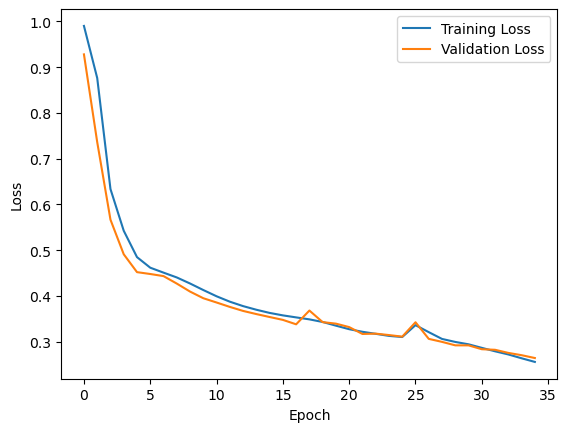

In [208]:
### START CODE HERE ###
# Construct the model & Set the parameters.
input_size = 6  # Number of input features (1 for single sine wave value)
rnn_units = 256  # Number of units in the RNN layer  # 64
dense_units = 128  # Number of units in the Dense layer  # 32
output_size = 3  # Number of output classes

model = Model()
model.add(RNN(input_size, rnn_units))
# model.add(RNN(rnn_units, rnn_units))
model.add(Dense(rnn_units, rnn_units))
model.add(Activation("relu", None))
model.add(Dense(rnn_units, dense_units))
model.add(Activation("relu", None))
model.add(Dense(dense_units, 64))
model.add(Activation("relu", None))
model.add(Dense(64, output_size))
model.add(Activation("softmax", None))

# model = Model()
# model.add(RNN(input_size, 16))
# model.add(RNN(16, rnn_units))
# model.add(Dense(rnn_units, rnn_units))
# model.add(Activation("relu", None))
# model.add(Dense(rnn_units, dense_units))
# model.add(Activation("relu", None))
# model.add(Dense(dense_units, 64))
# model.add(Activation("relu", None))
# model.add(Dense(64, output_size))
# model.add(Activation("softmax", None))

# Train the model
model.train(X_train, y_train, X_val, y_val, epochs=35, learning_rate=0.02, batch_size = 32, loss_function='cce')  # 50, 0.008, 32

### END CODE HERE ###
# Plot the training and validation losses
model.plot_losses()

### 4. Predict the output and Save it
Remember to submit `y_pred.csv` to Kaggle!

In [209]:
# Do not modify this part to get the correct output format!!
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Save the predicted classes to a CSV file
y_pred_df = pd.DataFrame({
    'Id': np.arange(len(y_pred_classes)),
    'Classes': y_pred_classes
})

# Save the DataFrame to a CSV file
y_pred_df.to_csv('y_pred_advanced.csv', index=False)